In [1]:
import keras
# from tensorflow.keras import layers
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LeakyReLU

from keras import callbacks
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint, EarlyStopping




%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

2023-06-04 10:28:40.782144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 10:28:41.971475: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-04 10:28:46.304488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-04 10:28:46.304767: W tensorflow/strea

tf.Tensor(-671.874, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# <font color=maroon>Model Building (Baseline) - Efficient Net

### Import

In [2]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [3]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model

In [4]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet')
pre_model.trainable = False
pre_model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

In [5]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Test')

model.add(tf.keras.layers.Rescaling(scale=255))
# model.add(tf.keras.layers.TimeDistributed(pre_model))
model.add(pre_model)
model.add(Dense(10))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

# model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'))

Epoch 1/50


2023-06-04 10:29:14.785908: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-04 10:29:16.493068: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-04 10:29:16.494388: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-04 10:29:16.494445: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-04 10:29:16.495447: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-04 10:29:16.495567: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


391/391 [==============================] - 57s 99ms/step - loss: 0.6171 - accuracy: 0.8083 - val_loss: 0.3662 - val_accuracy: 0.8813
Epoch 2/50
391/391 [==============================] - 43s 109ms/step - loss: 0.3556 - accuracy: 0.8786 - val_loss: 0.3205 - val_accuracy: 0.8946
Epoch 3/50
391/391 [==============================] - 43s 109ms/step - loss: 0.3143 - accuracy: 0.8924 - val_loss: 0.3000 - val_accuracy: 0.9003
Epoch 4/50
391/391 [==============================] - 37s 95ms/step - loss: 0.2943 - accuracy: 0.8991 - val_loss: 0.2902 - val_accuracy: 0.9029
Epoch 5/50
391/391 [==============================] - 47s 120ms/step - loss: 0.2761 - accuracy: 0.9042 - val_loss: 0.2821 - val_accuracy: 0.9051
Epoch 6/50
391/391 [==============================] - 42s 107ms/step - loss: 0.2659 - accuracy: 0.9086 - val_loss: 0.2749 - val_accuracy: 0.9080
Epoch 7/50
391/391 [==============================] - 38s 97ms/step - loss: 0.2569 - accuracy: 0.9121 - val_loss: 0.2735 - val_accuracy: 0.9072

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

79/79 [==============================] - 6s 76ms/step - loss: 0.2673 - accuracy: 0.9099
Test loss:  0.2673124670982361
Test accuracy: 0.9099000096321106


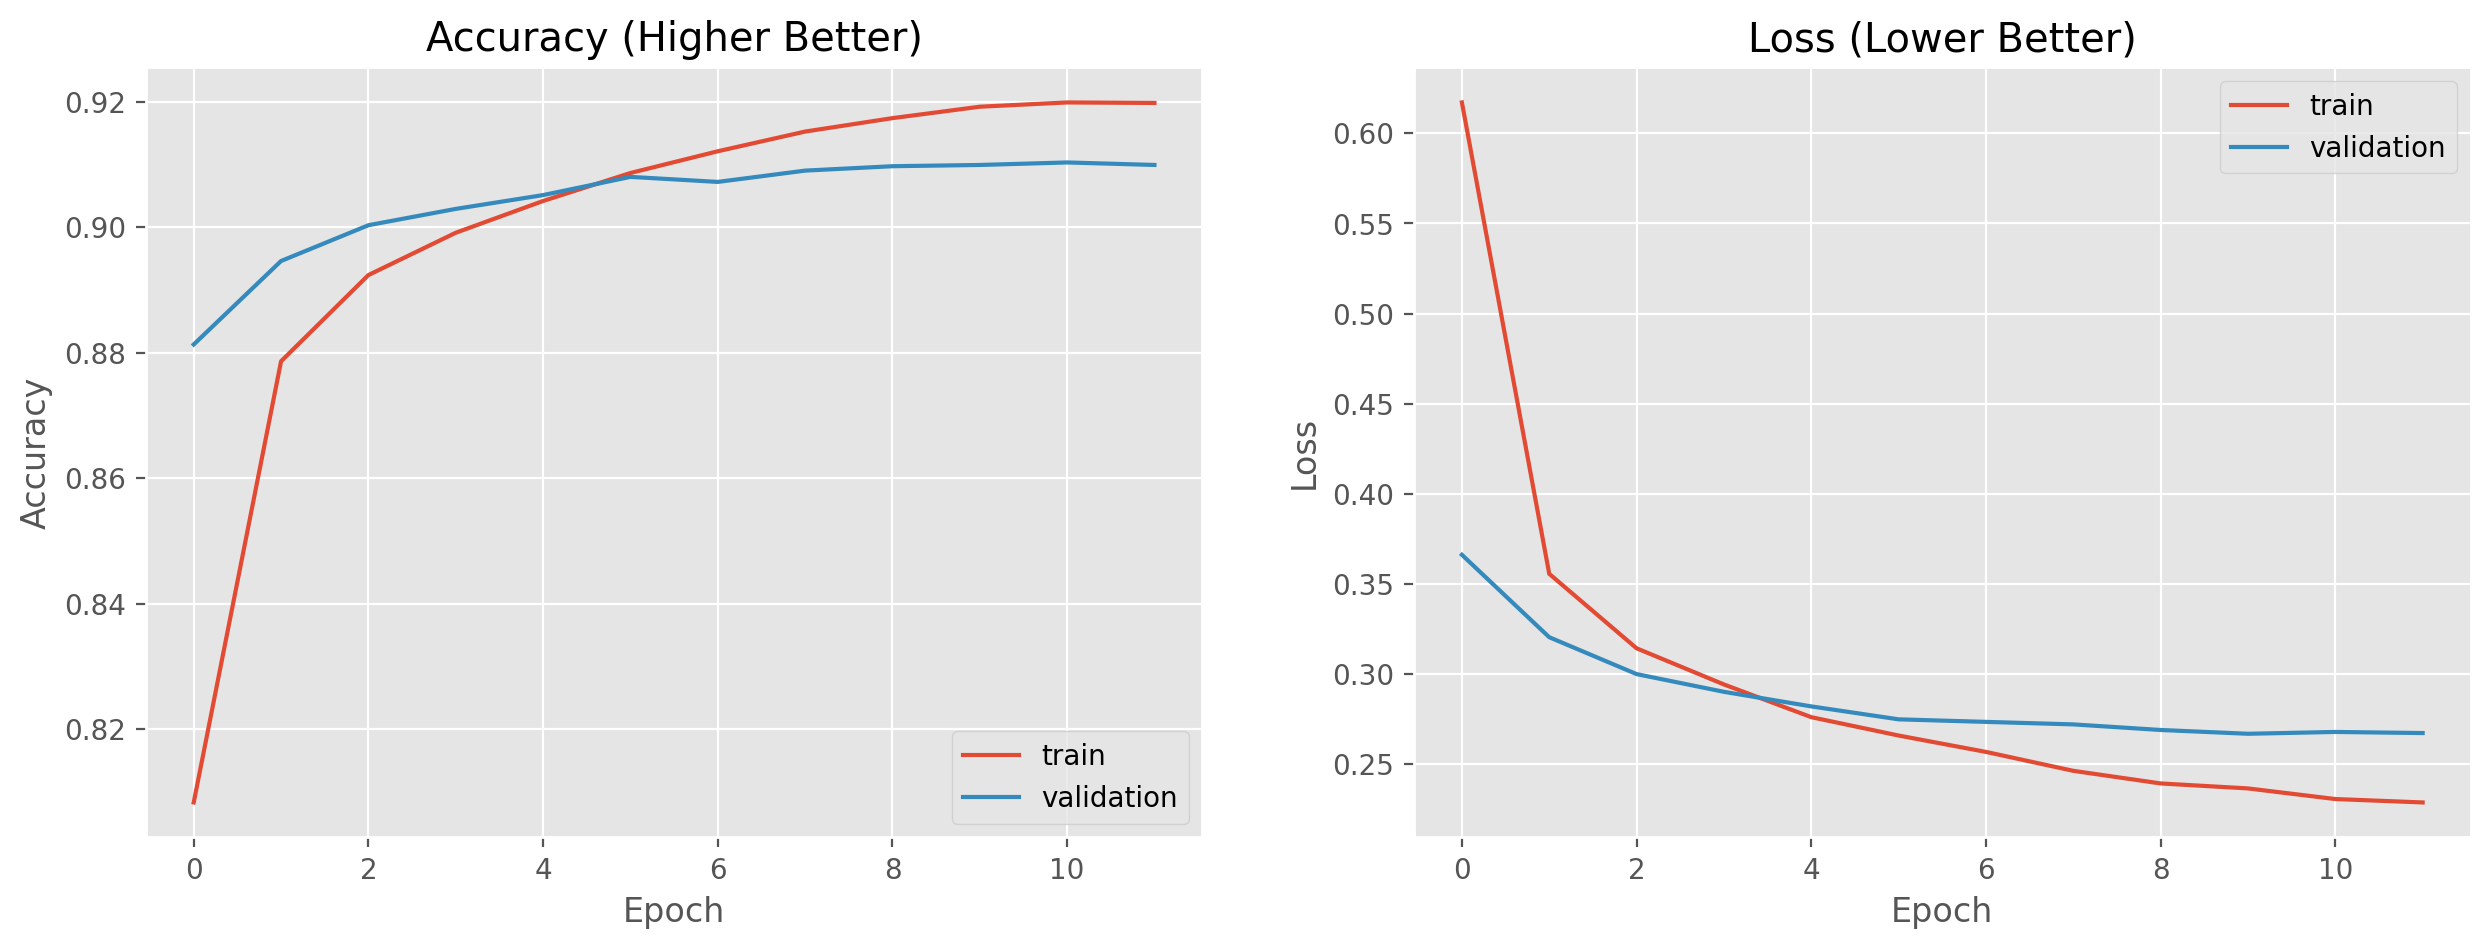

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [8]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

79/79 [==============================] - 7s 73ms/step
[3 8 8 ... 5 1 7]


In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [10]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [11]:
print(err_x.shape)

(1000, 32, 32, 3)


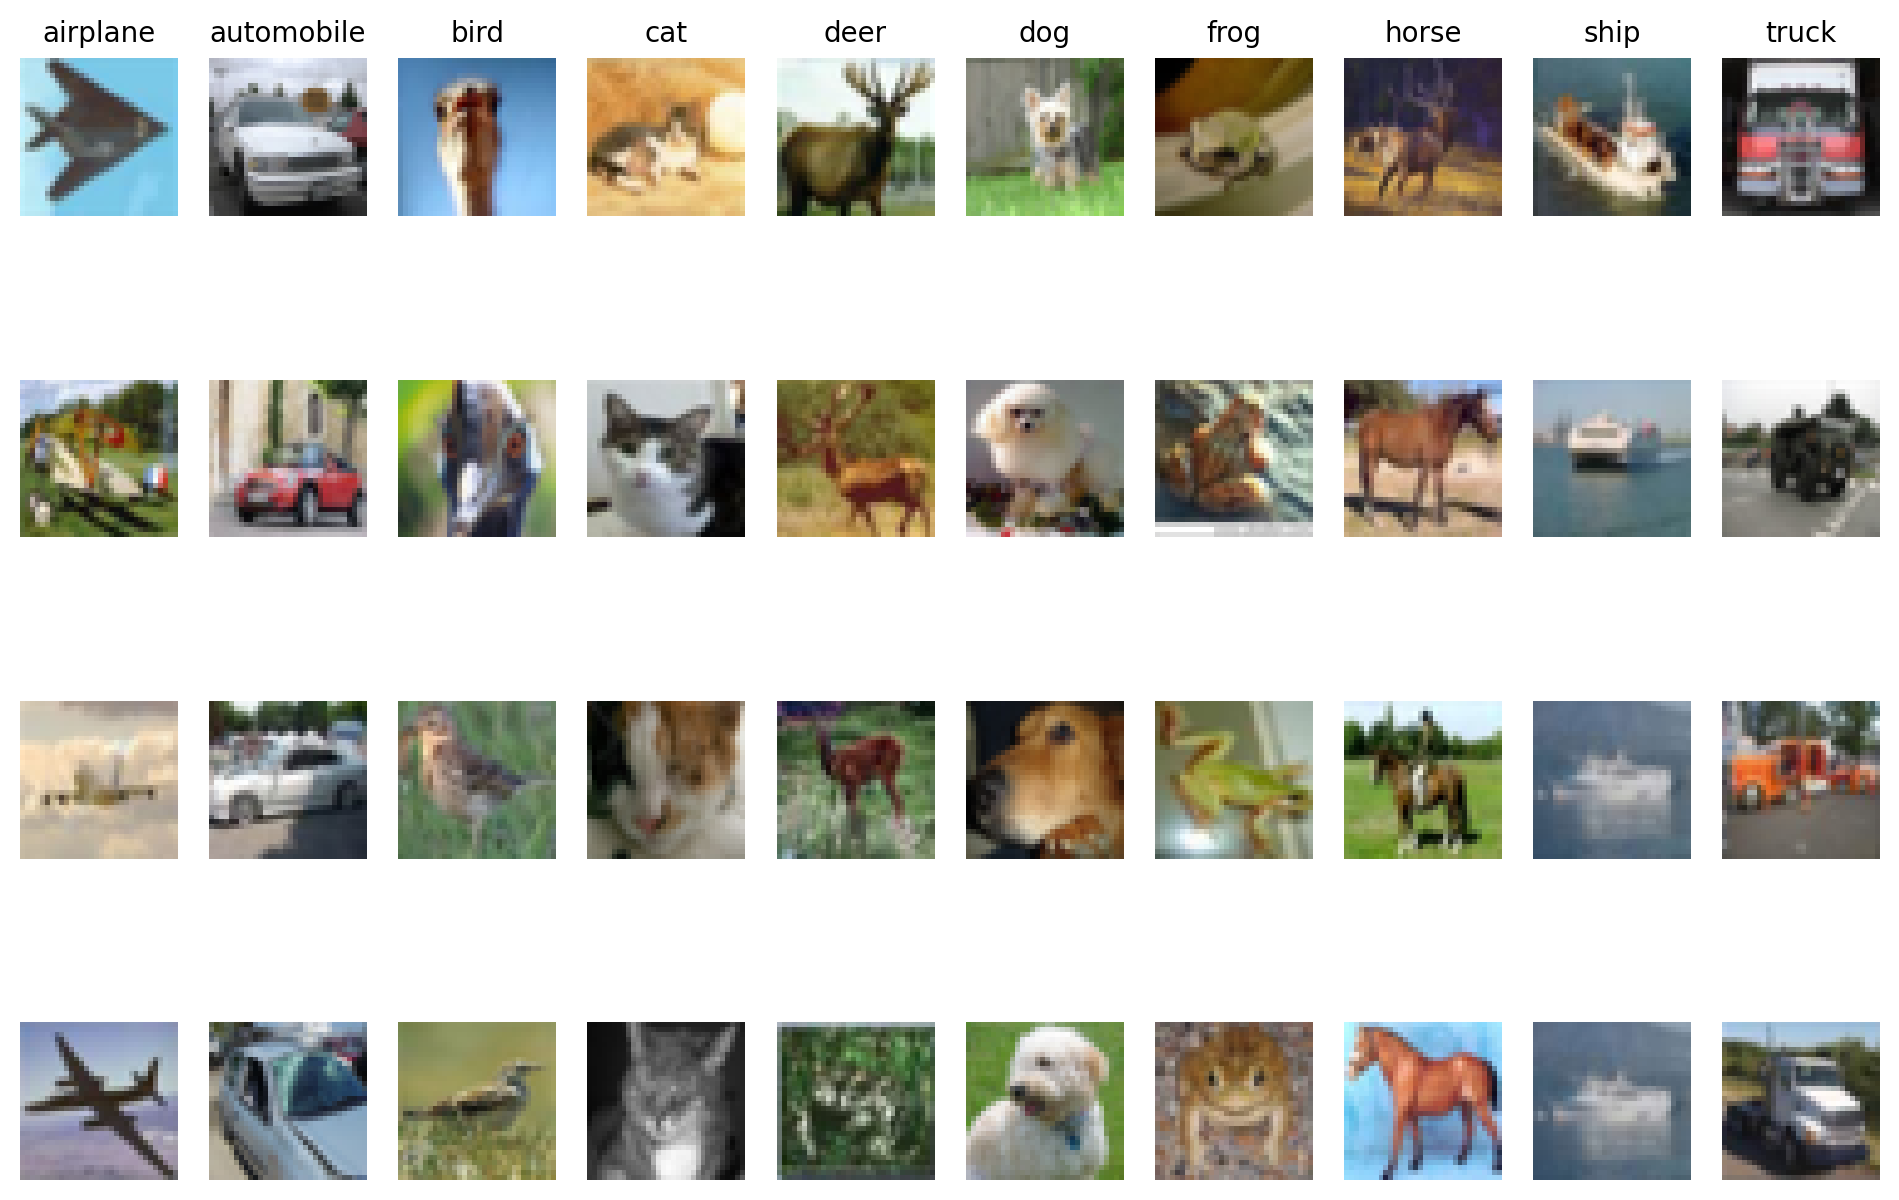

In [12]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


In [13]:
import requests
from PIL import Image
from io import BytesIO

In [14]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

In [15]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [16]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [17]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 2s 2s/step


In [18]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [19]:
predicted_label = class_labels[predicted_class_index[0]]

In [20]:
print(predicted_label)


deer


### <font color=maroon>Visualising confusion matrix

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [22]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [23]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.9099


In [24]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.9099402143524332
Recall: 0.9099
F1 Score: 0.9097685751041208


### Creating confusion matrix

In [25]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

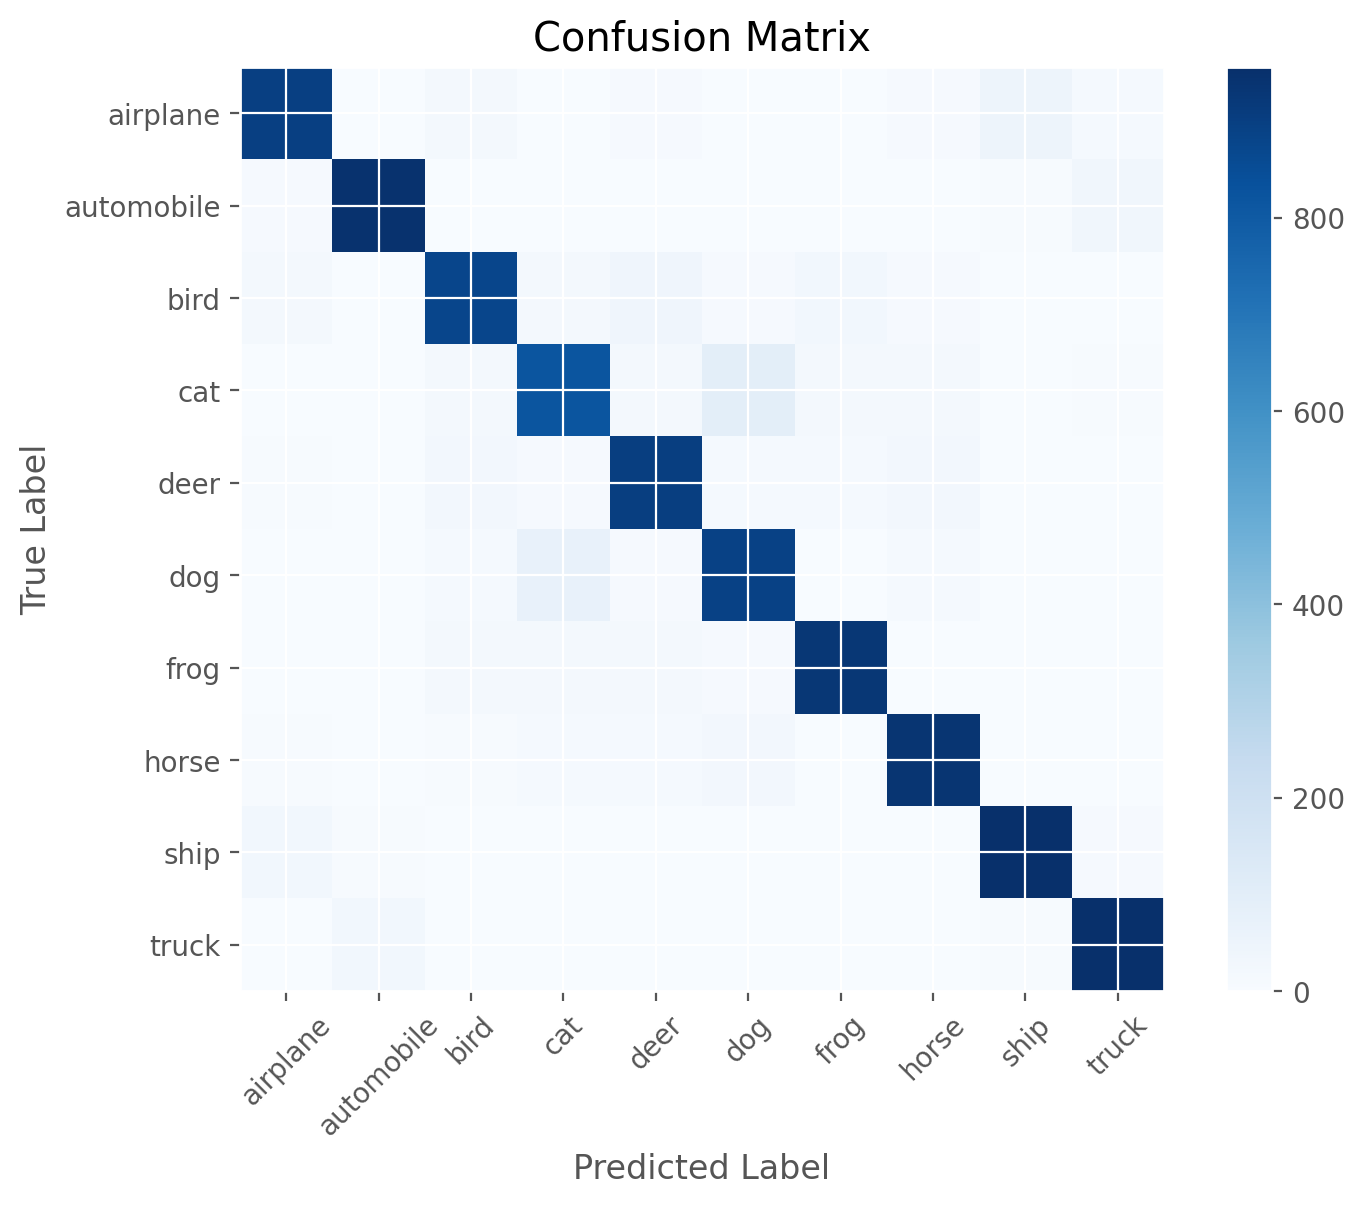

In [26]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [27]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.93      0.90      0.91      1000
  automobile       0.96      0.94      0.95      1000
        bird       0.89      0.88      0.88      1000
         cat       0.85      0.82      0.84      1000
        deer       0.89      0.90      0.90      1000
         dog       0.85      0.89      0.87      1000
        frog       0.93      0.93      0.93      1000
       horse       0.92      0.94      0.93      1000
        ship       0.93      0.95      0.94      1000
       truck       0.93      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### <font color=maroon>Model Evaluation</font> 
- When looking at our baseline mode, we can see that our accuracy reached 0.91 with a test loss of about 0.26. 
- As compared to our other models, our baseline performed significantly better than InceptionV3, ResNet and VGG, moreover mlp and lenet5
- However, when looking at our results, it is relatively decent and through fine tuning, we are abelt o boost our results using various methods- 


### <font color=purple>Methods to try</font>
- Layer unfreezing,
- BUilding from scratch
- Including top and creating our own dense layers or final layers
- Data augmentation 
- 

# <font color=maroon>Model Building Tuned 1 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

Model: "efficientnetb0"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                

                                                                                                  

 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              

                                                                                                  

 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normali

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_1')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

# model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'))

Epoch 1/50

782/782 [==============================] - 196s 188ms/step - loss: 0.3326 - accuracy: 0.8882 - val_loss: 0.4454 - val_accuracy: 0.8551

Epoch 2/50

782/782 [==============================] - 145s 186ms/step - loss: 0.1668 - accuracy: 0.9428 - val_loss: 0.2401 - val_accuracy: 0.9261

Epoch 3/50

782/782 [==============================] - 145s 185ms/step - loss: 0.1280 - accuracy: 0.9565 - val_loss: 0.2540 - val_accuracy: 0.9207

Epoch 4/50

782/782 [==============================] - 145s 185ms/step - loss: 0.1062 - accuracy: 0.9631 - val_loss: 0.3172 - val_accuracy: 0.9144

Epoch 5/50

782/782 [==============================] - 145s 186ms/step - loss: 0.0909 - accuracy: 0.9688 - val_loss: 0.2400 - val_accuracy: 0.9306

Epoch 6/50

782/782 [==============================] - 145s 185ms/step - loss: 0.0777 - accuracy: 0.9727 - val_loss: 0.3192 - val_accuracy: 0.9189

Epoch 7/50

782/782 [==============================] - 145s 185ms/step - loss: 0.0712 - accuracy: 0.9756 - val_l

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 6s 40ms/step - loss: 0.2360 - accuracy: 0.9449

Test loss:  0.2360343039035797

Test accuracy: 0.9448999762535095


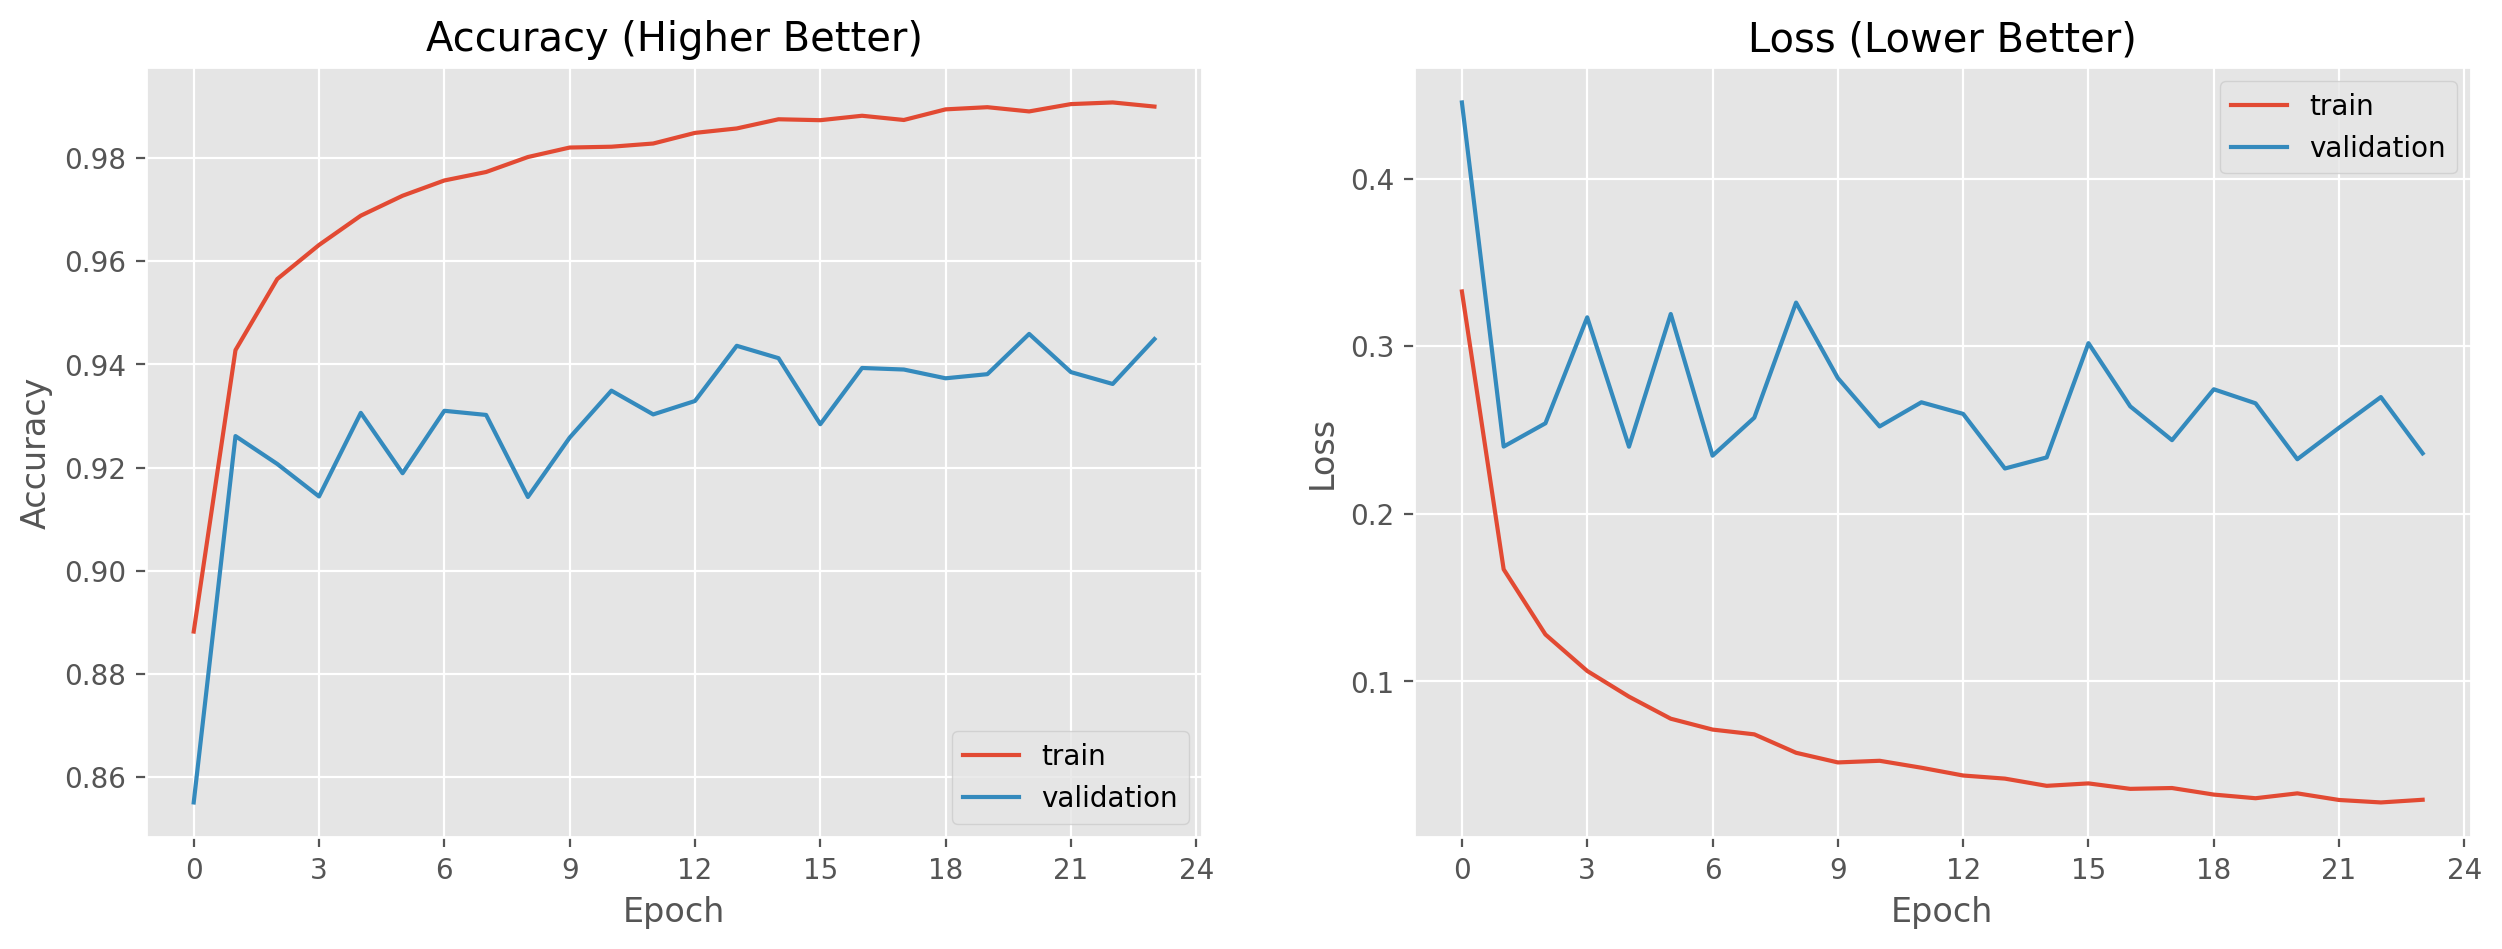

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 7s 36ms/step

[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-12-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


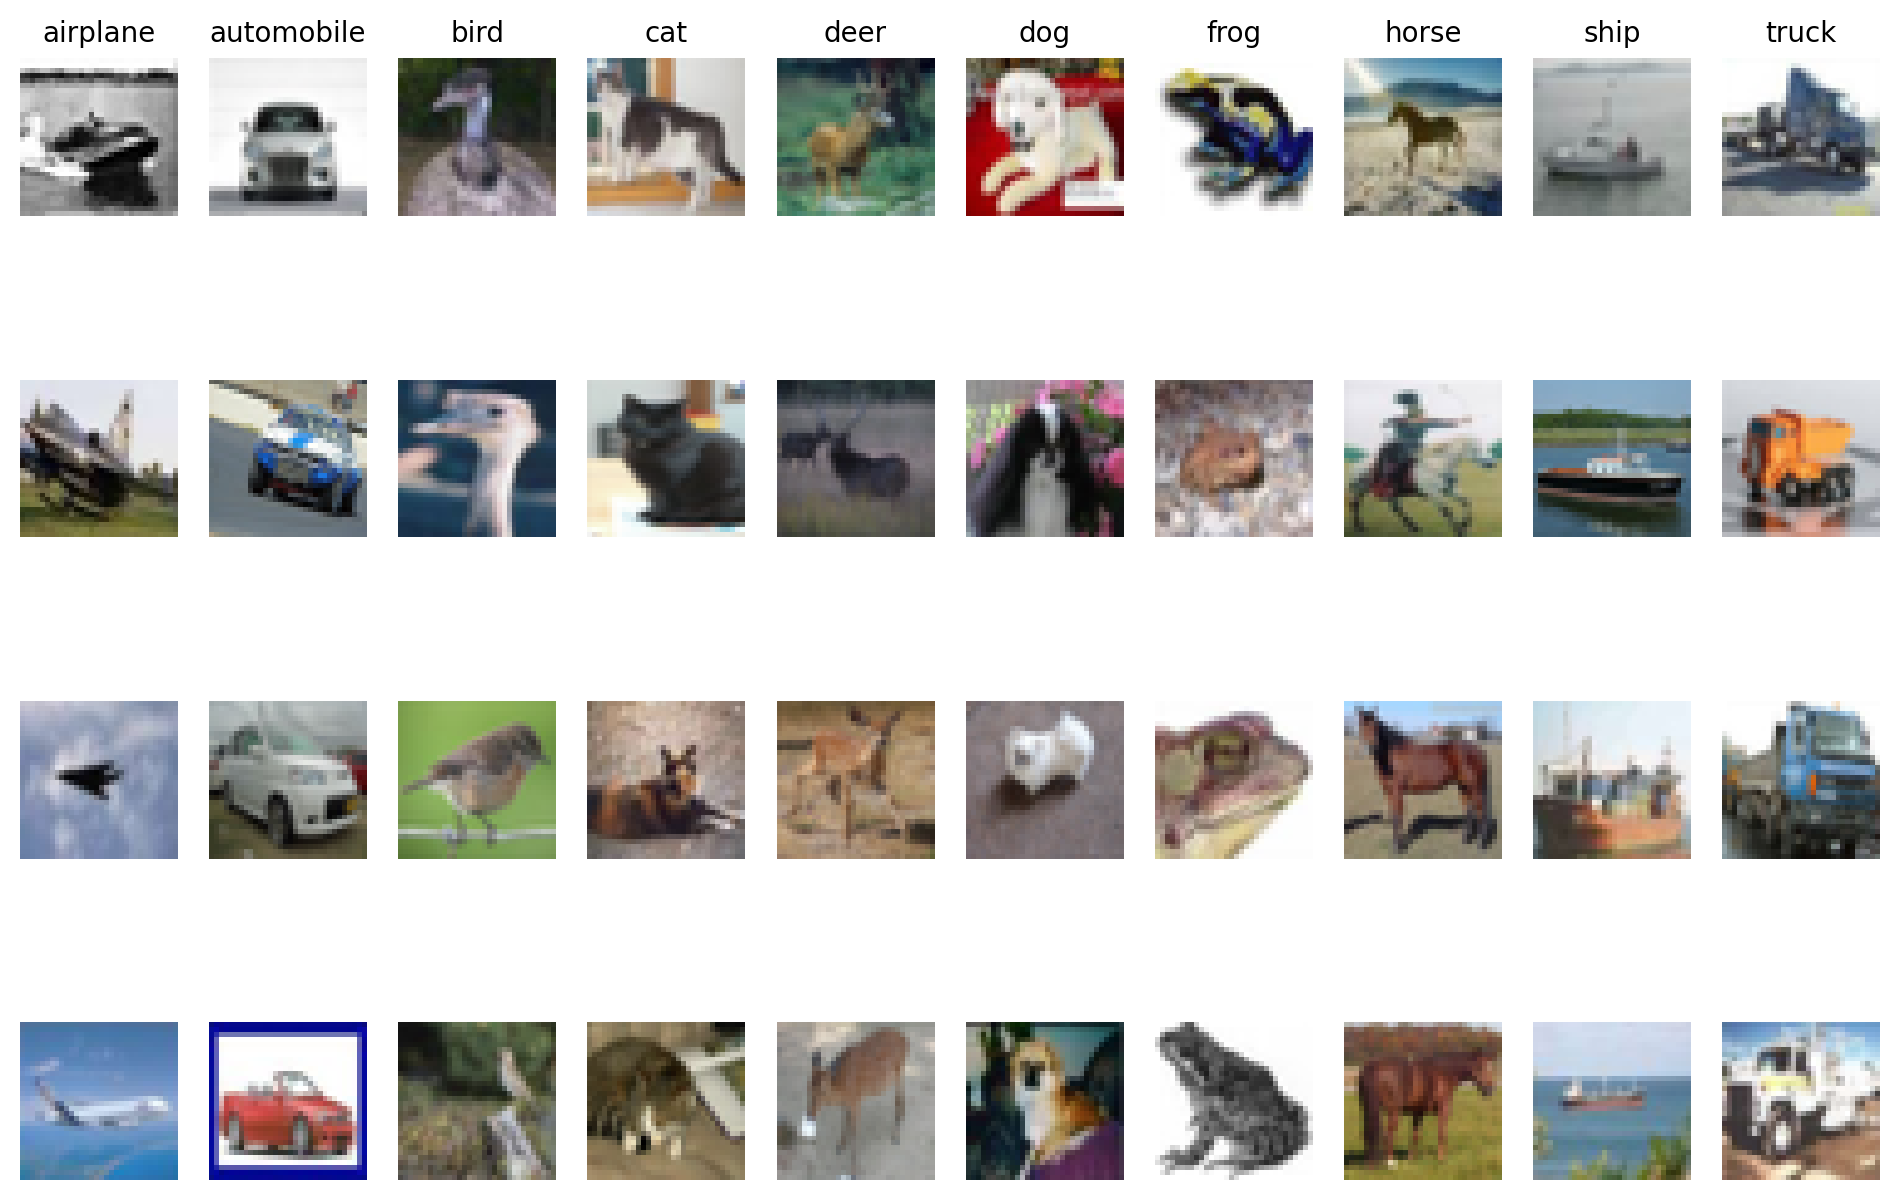

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 2 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10
- Added learning rate scheduler.

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

Model: "efficientnetb0"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                

                                                                                                  

 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              

                                                                                                  

 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normali

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_2')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

# model.summary()

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Epoch 1/50

782/782 [==============================] - 196s 189ms/step - loss: 2.0135 - accuracy: 0.3376 - val_loss: 1.5558 - val_accuracy: 0.6235 - lr: 3.2258e-06

Epoch 2/50

782/782 [==============================] - 145s 185ms/step - loss: 1.2635 - accuracy: 0.6935 - val_loss: 0.8895 - val_accuracy: 0.7897 - lr: 3.2258e-06

Epoch 3/50

782/782 [==============================] - 145s 185ms/step - loss: 0.8038 - accuracy: 0.7926 - val_loss: 0.5858 - val_accuracy: 0.8460 - lr: 3.2258e-06

Epoch 4/50

782/782 [==============================] - 145s 185ms/step - loss: 0.5881 - accuracy: 0.8347 - val_loss: 0.4397 - val_accuracy: 0.8738 - lr: 3.2258e-06

Epoch 5/50

782/782 [==============================] - 145s 185ms/step - loss: 0.4764 - accuracy: 0.8590 - val_loss: 0.3573 - val_accuracy: 0.8946 - lr: 3.2258e-06

Epoch 6/50

782/782 [==============================] - 145s 185ms/step - loss: 0.4011 - accuracy: 0.8763 - val_loss: 0.3068 - val_accuracy: 0.9076 - lr: 3.2258e-06

Epoch 7/50

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 6s 40ms/step - loss: 0.1171 - accuracy: 0.9622

Test loss:  0.11712684482336044

Test accuracy: 0.9621999859809875


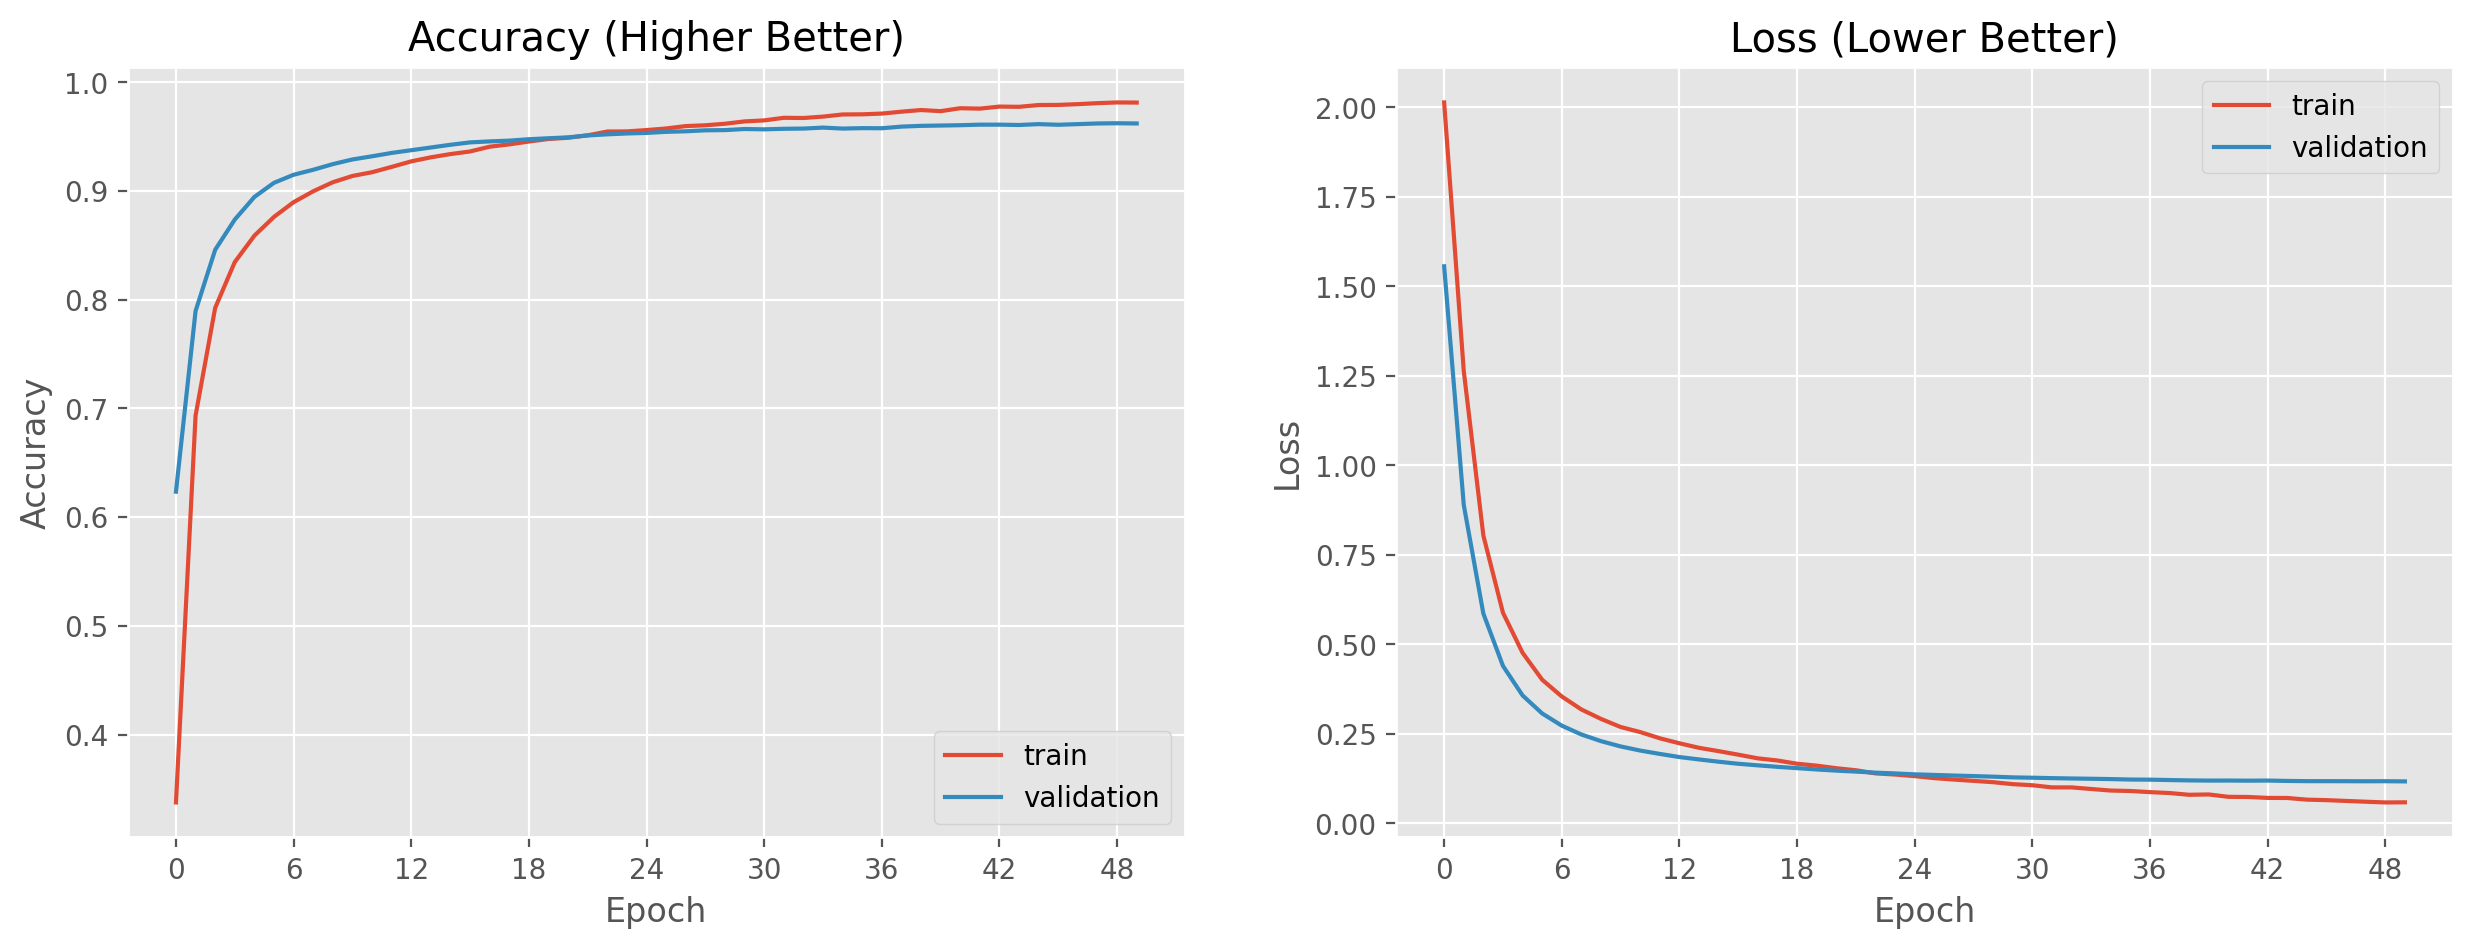

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

NameError: ignored

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 3 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10
- Added learning rate scheduler.
- Increased epoch to 100 
- Increased Early Stopper to 20 

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

Model: "efficientnetb0"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                

                                                                                                  

 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              

                                                                                                  

 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normali

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_3')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 100

# model.summary()

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Epoch 1/100

782/782 [==============================] - 194s 186ms/step - loss: 1.9779 - accuracy: 0.3595 - val_loss: 1.5490 - val_accuracy: 0.6159 - lr: 3.2258e-06

Epoch 2/100

782/782 [==============================] - 144s 184ms/step - loss: 1.2784 - accuracy: 0.6892 - val_loss: 0.9207 - val_accuracy: 0.7812 - lr: 3.2258e-06

Epoch 3/100

782/782 [==============================] - 143s 183ms/step - loss: 0.8235 - accuracy: 0.7888 - val_loss: 0.6022 - val_accuracy: 0.8410 - lr: 3.2258e-06

Epoch 4/100

782/782 [==============================] - 143s 183ms/step - loss: 0.5939 - accuracy: 0.8348 - val_loss: 0.4502 - val_accuracy: 0.8716 - lr: 3.2258e-06

Epoch 5/100

782/782 [==============================] - 144s 184ms/step - loss: 0.4764 - accuracy: 0.8596 - val_loss: 0.3670 - val_accuracy: 0.8923 - lr: 3.2258e-06

Epoch 6/100

782/782 [==============================] - 144s 184ms/step - loss: 0.4066 - accuracy: 0.8752 - val_loss: 0.3144 - val_accuracy: 0.9039 - lr: 3.2258e-06

Epoc

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 6s 39ms/step - loss: 0.1198 - accuracy: 0.9622

Test loss:  0.11984709650278091

Test accuracy: 0.9621999859809875


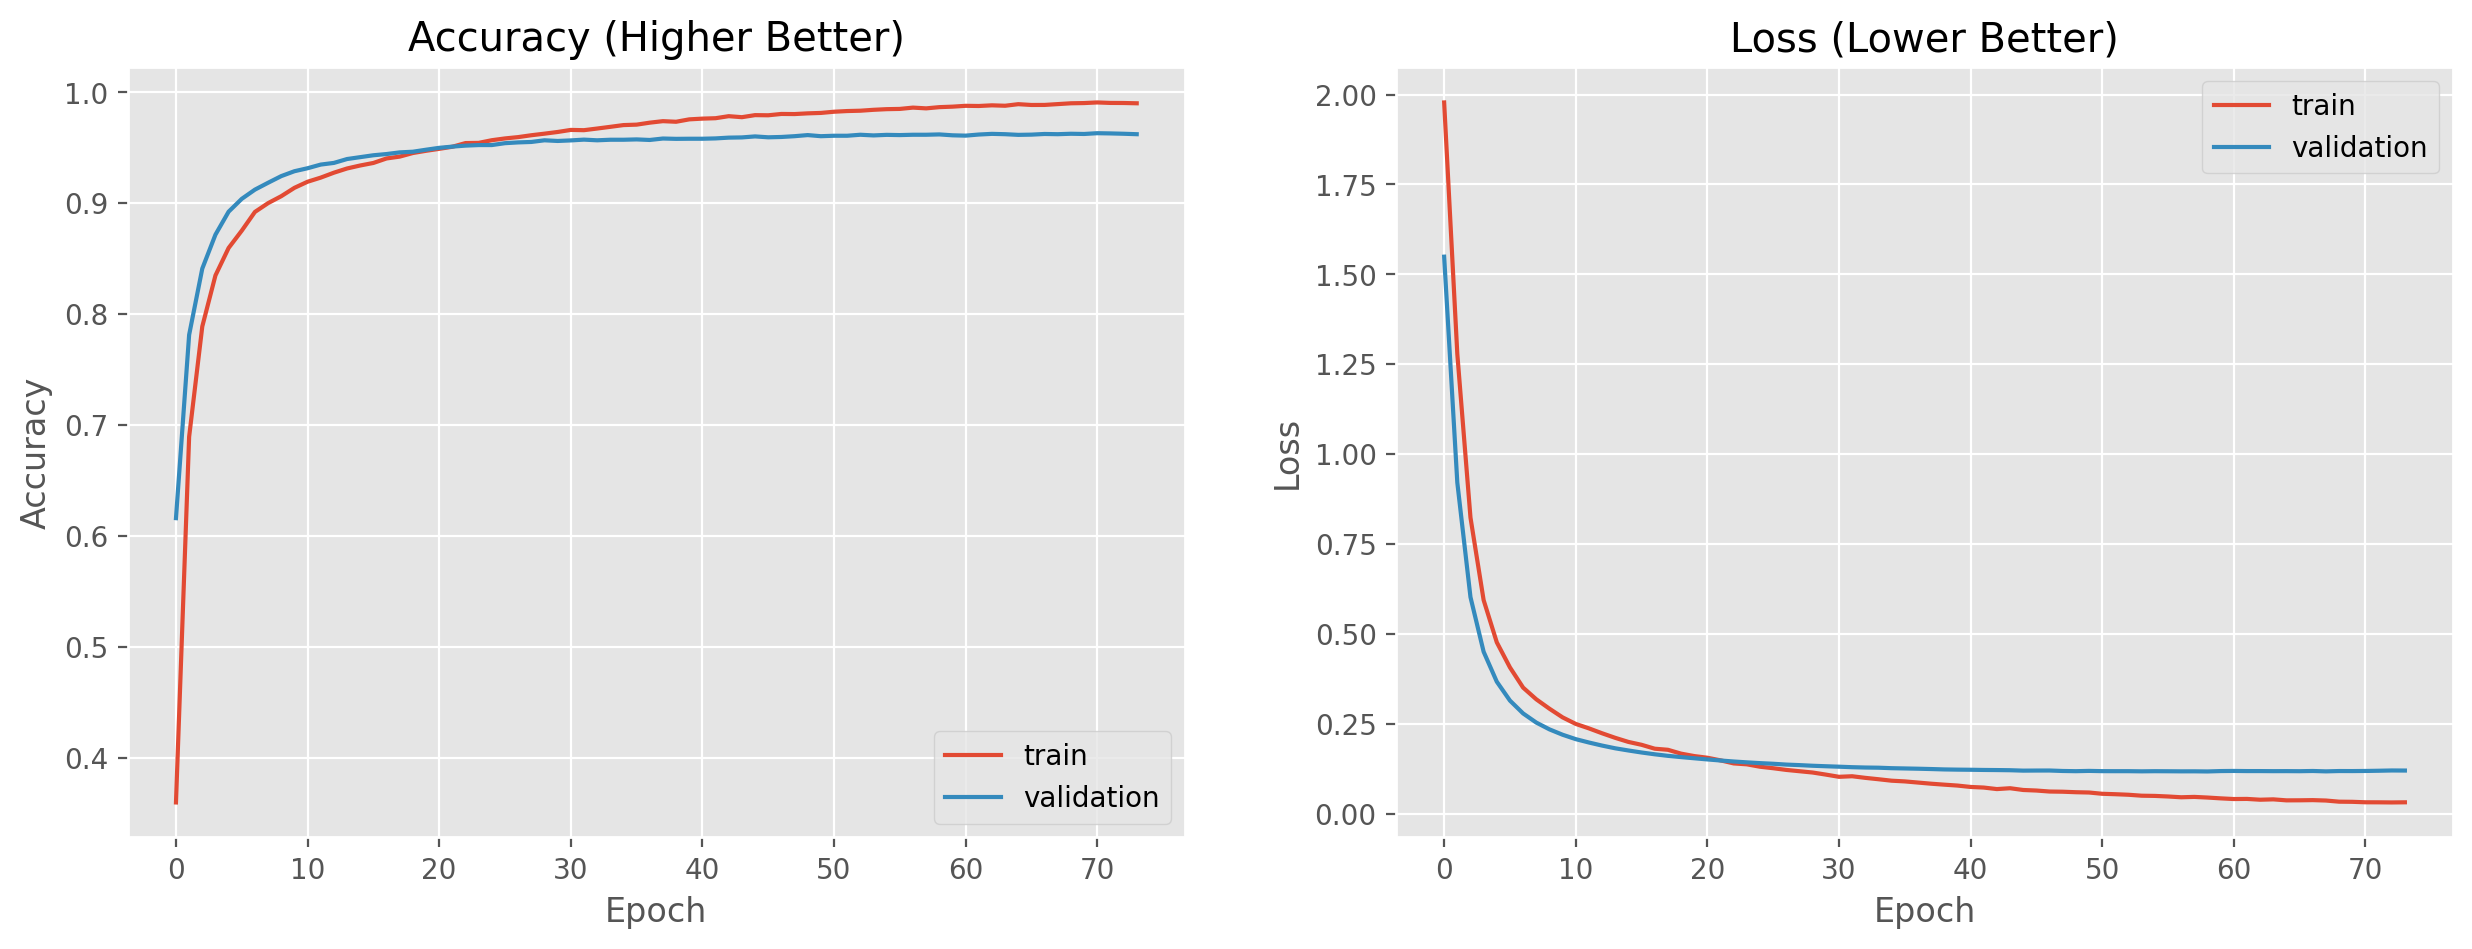

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 7s 36ms/step

[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-12-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


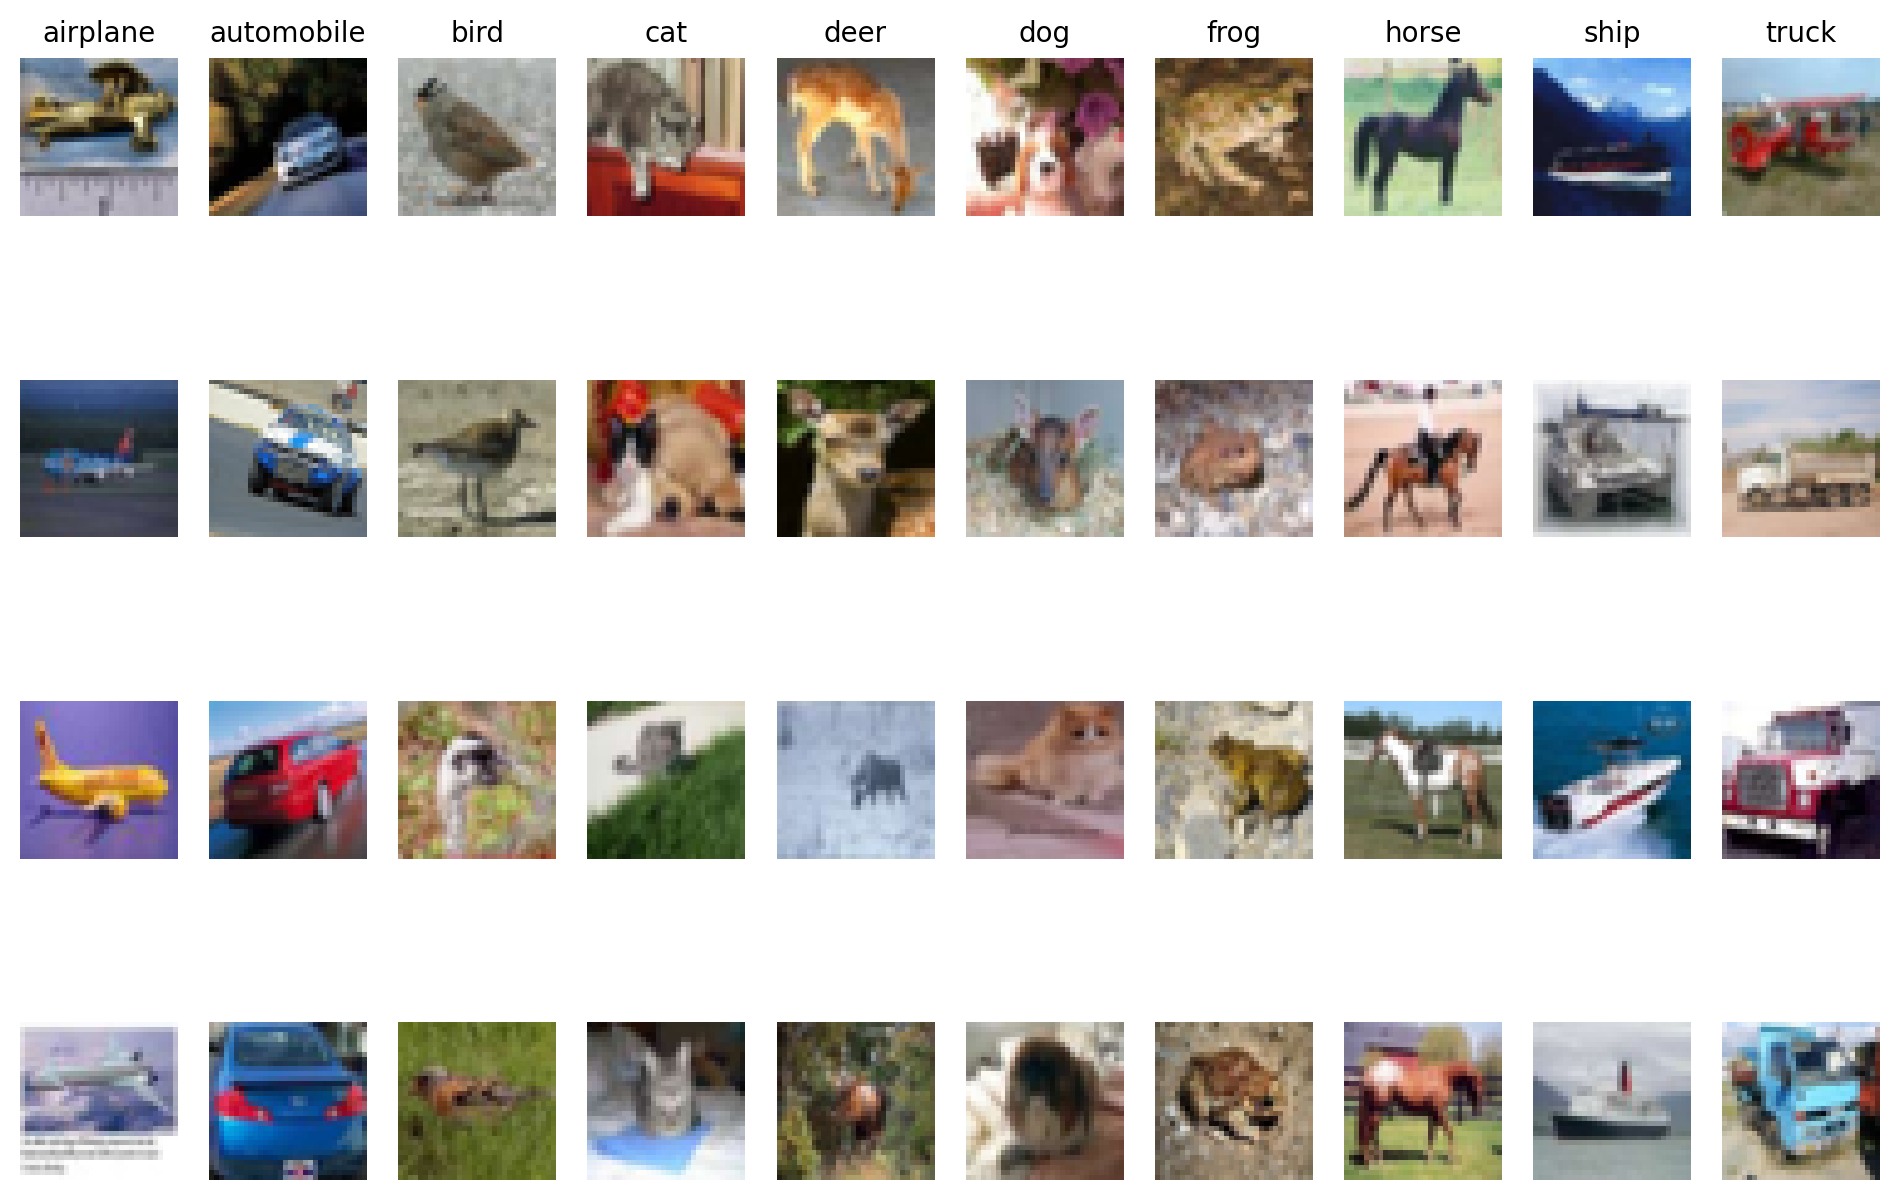

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 4 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# def format_image(image, label):

#     # Resize the image
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

#     # Apply data augmentation
#     image = tf.image.random_flip_left_right(image)  # Random horizontal flip
#     image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
#     image = tf.image.random_crop(image, size=[int(IMG_SIZE * 0.9), int(IMG_SIZE * 0.9), 3])  # Random crop to enable shift augmentation
#     image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize back after crop
    
    
#     return image, label

# def format_image2(image, label):
#     # Resize the image
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    
# # Create TensorFlow dataset objects for the training and test sets
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# batch_size = 64
# # Preprocess, batch, and prefetch the datasets
# train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
# test_set = test_ds.map(format_image2).batch(batch_size).prefetch(1)

# print(train_set)
# print(test_set)

def format_image(image, label):
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Apply data augmentation
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
    image = tf.image.random_crop(image, size=[int(IMG_SIZE * 0.9), int(IMG_SIZE * 0.9), 3])  # Random crop to enable shift augmentation
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize back after crop

    return image, label

def format_image2(image, label):
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    return image, label

batch_size = 64

# Create TensorFlow Datasets for training and testing
training_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply resizing, normalization, and data augmentation
train_set = training_set.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_set.map(format_image2).batch(batch_size).prefetch(1)


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10
- Added learning rate scheduler.
- Increased epoch to 100 
- Added Image Augmentation

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_4')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 100

# model.summary()

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Epoch 1/100


2023-05-30 02:20:44.504277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet_Tuned_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 [==============================] - 367s 401ms/step - loss: 2.1970 - accuracy: 0.2167 - val_loss: 1.9432 - val_accuracy: 0.4143 - lr: 3.2258e-06
Epoch 2/100
782/782 [==============================] - 313s 400ms/step - loss: 1.7348 - accuracy: 0.4703 - val_loss: 1.4538 - val_accuracy: 0.6334 - lr: 3.2258e-06
Epoch 3/100
782/782 [==============================] - 315s 402ms/step - loss: 1.3522 - accuracy: 0.5893 - val_loss: 1.0820 - val_accuracy: 0.7143 - lr: 3.2258e-06
Epoch 4/100
782/782 [==============================] - 313s 401ms/step - loss: 1.1128 - accuracy: 0.6465 - val_loss: 0.8622 - val_accuracy: 0.7536 - lr: 3.2258e-06
Epoch 5/100
782/782 [==============================] - 312s 399ms/step - loss: 0.9669 - accuracy: 0.6822 - val_loss: 0.7308 - val_accuracy: 0.7791 - lr: 3.2258e-06
Epoch 6/100
782/782 [==============================] - 313s 400ms/step - loss: 0.8684 - accuracy: 0.7115 - val_loss: 0.6388 - val_accuracy: 0.8054 - lr: 3.2258e-06
Epoch 7/100
782/782 [=======

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 11s 67ms/step - loss: 0.1578 - accuracy: 0.9451
Test loss:  0.15778259932994843
Test accuracy: 0.9451000094413757


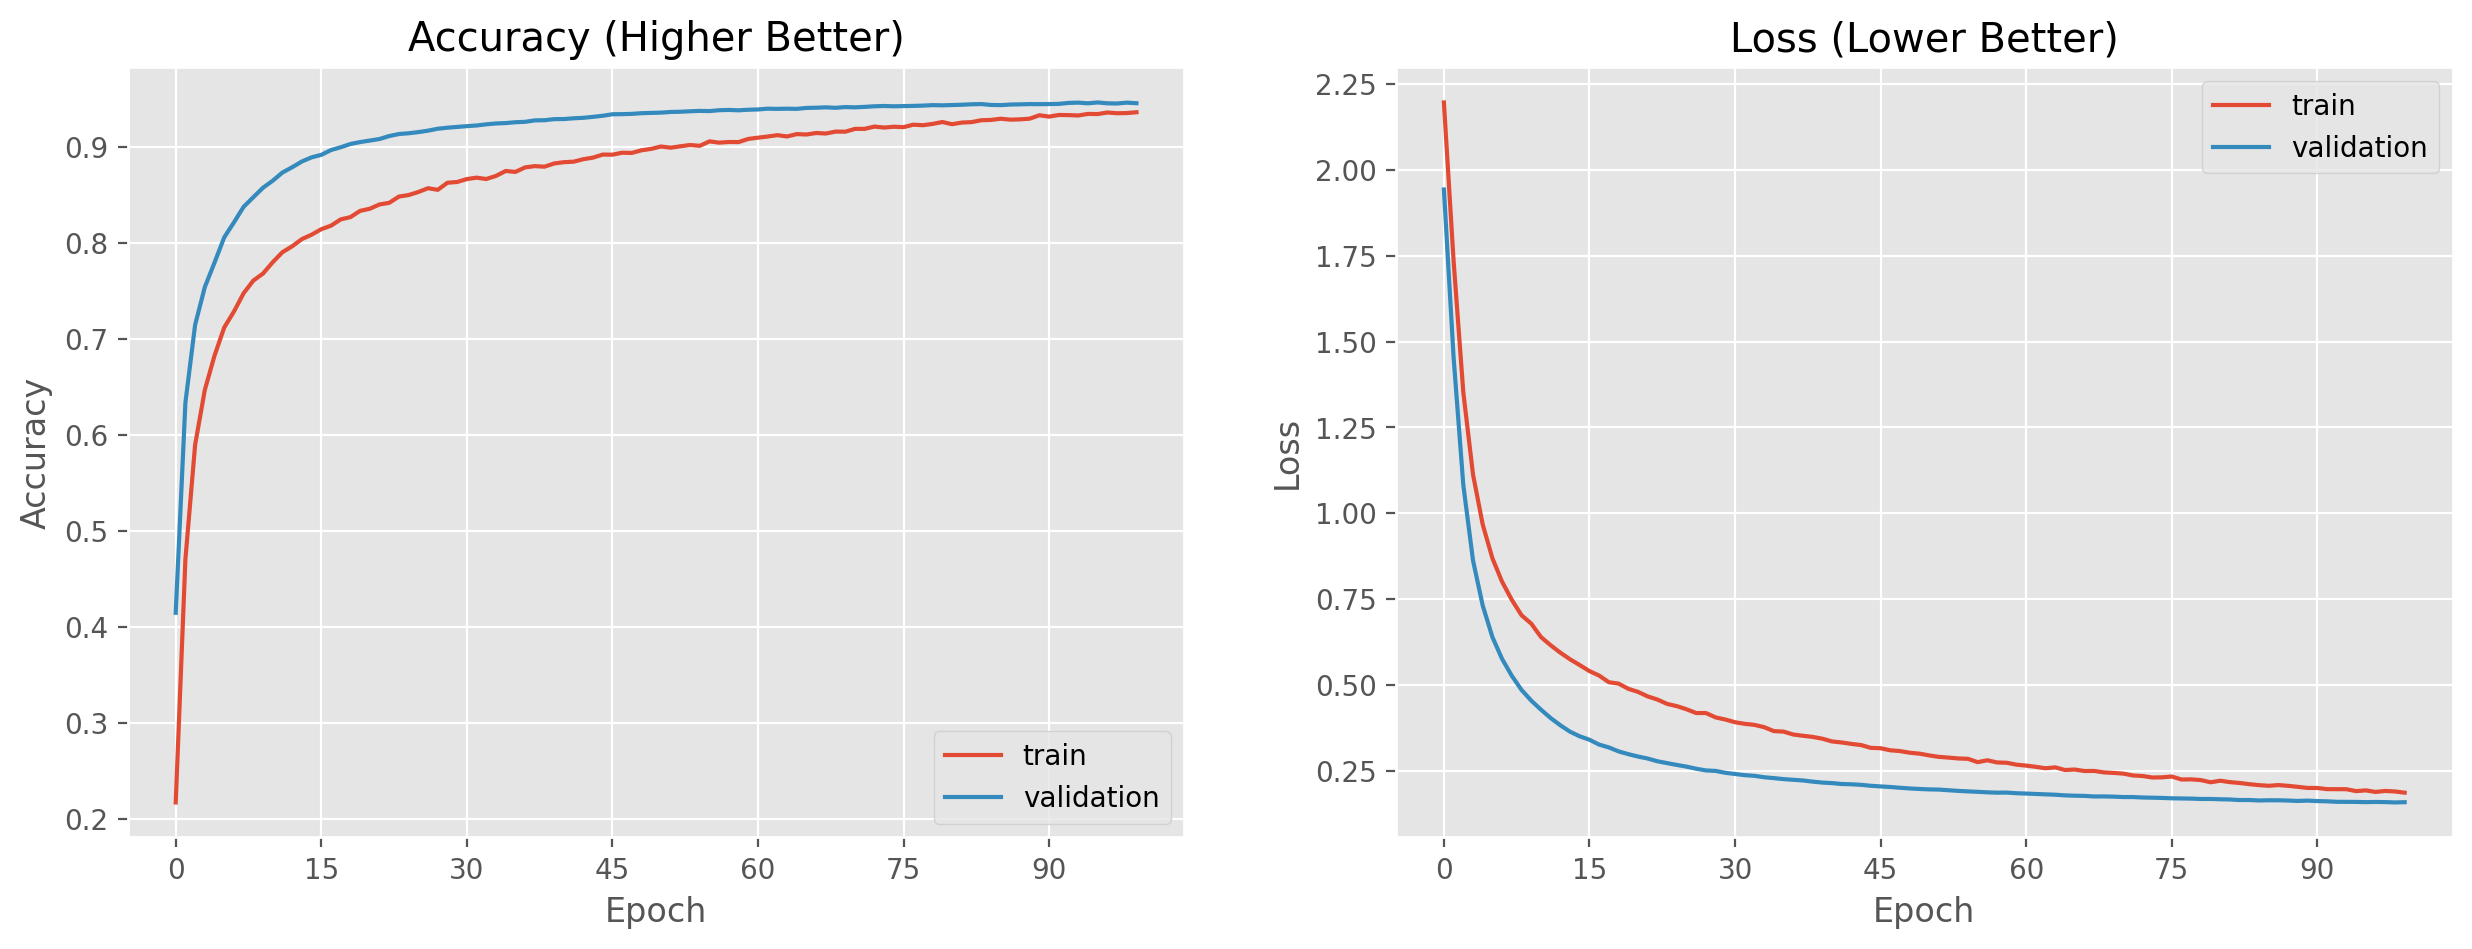

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 12s 64ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


/tmp/ipykernel_29/2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


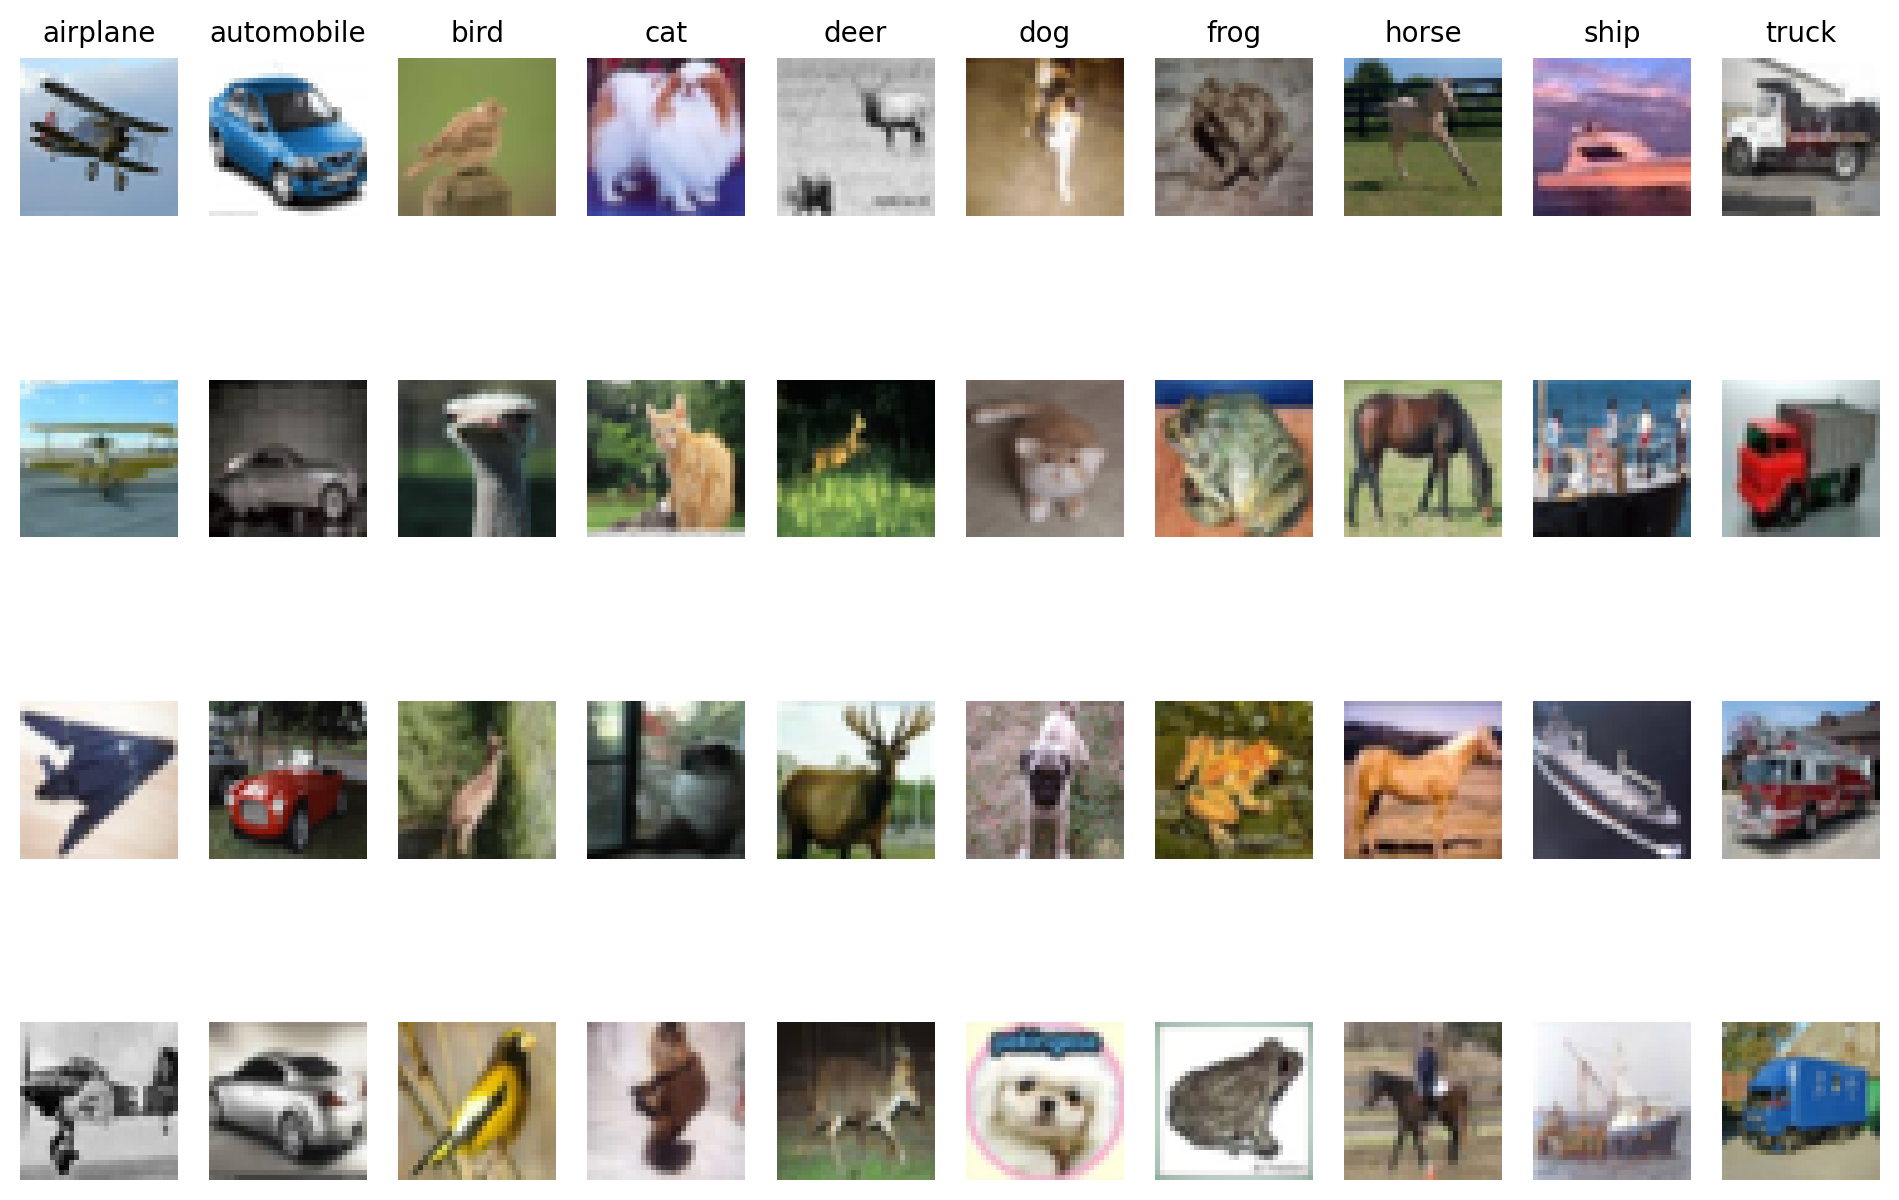

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


In [ ]:
# convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# <font color=maroon>Model Building Tuned 5 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


def format_image(image, label):
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Apply data augmentation
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
    image = tf.image.random_crop(image, size=[int(IMG_SIZE * 0.9), int(IMG_SIZE * 0.9), 3])  # Random crop to enable shift augmentation
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize back after crop

    return image, label

def format_image2(image, label):
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    return image, label

batch_size = 64

# Create TensorFlow Datasets for training and testing
training_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply resizing, normalization, and data augmentation
train_set = training_set.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_set.map(format_image2).batch(batch_size).prefetch(1)


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10
- Added learning rate scheduler.
- Increased epoch to 100 
- Added Image Augmentation
- Increased number of epoch to 200
- Prevent learning rate from decaying after 10

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_4')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 200

# model.summary()

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)
    

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

2023-05-31 07:42:43.512227: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-05-31 07:42:44.045573: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 07:42:44.046542: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 07:42:44.046618: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-31 07:42:44.047600: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 07:42:44.047723: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


782/782 [==============================] - 128s 146ms/step - loss: 2.1391 - accuracy: 0.2437 - val_loss: 1.9147 - val_accuracy: 0.4269 - lr: 3.2258e-06
Epoch 2/200
782/782 [==============================] - 112s 143ms/step - loss: 1.6939 - accuracy: 0.4882 - val_loss: 1.4297 - val_accuracy: 0.6277 - lr: 3.2258e-06
Epoch 3/200
782/782 [==============================] - 112s 143ms/step - loss: 1.3257 - accuracy: 0.5981 - val_loss: 1.0749 - val_accuracy: 0.7085 - lr: 3.2258e-06
Epoch 4/200
782/782 [==============================] - 112s 143ms/step - loss: 1.0972 - accuracy: 0.6502 - val_loss: 0.8601 - val_accuracy: 0.7548 - lr: 3.2258e-06
Epoch 5/200
782/782 [==============================] - 112s 143ms/step - loss: 0.9593 - accuracy: 0.6835 - val_loss: 0.7291 - val_accuracy: 0.7821 - lr: 3.2258e-06
Epoch 6/200
782/782 [==============================] - 112s 143ms/step - loss: 0.8702 - accuracy: 0.7096 - val_loss: 0.6371 - val_accuracy: 0.8046 - lr: 3.2258e-06
Epoch 7/200
782/782 [=======

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 6s 40ms/step - loss: 0.1459 - accuracy: 0.9516
Test loss:  0.1459227204322815
Test accuracy: 0.9516000151634216


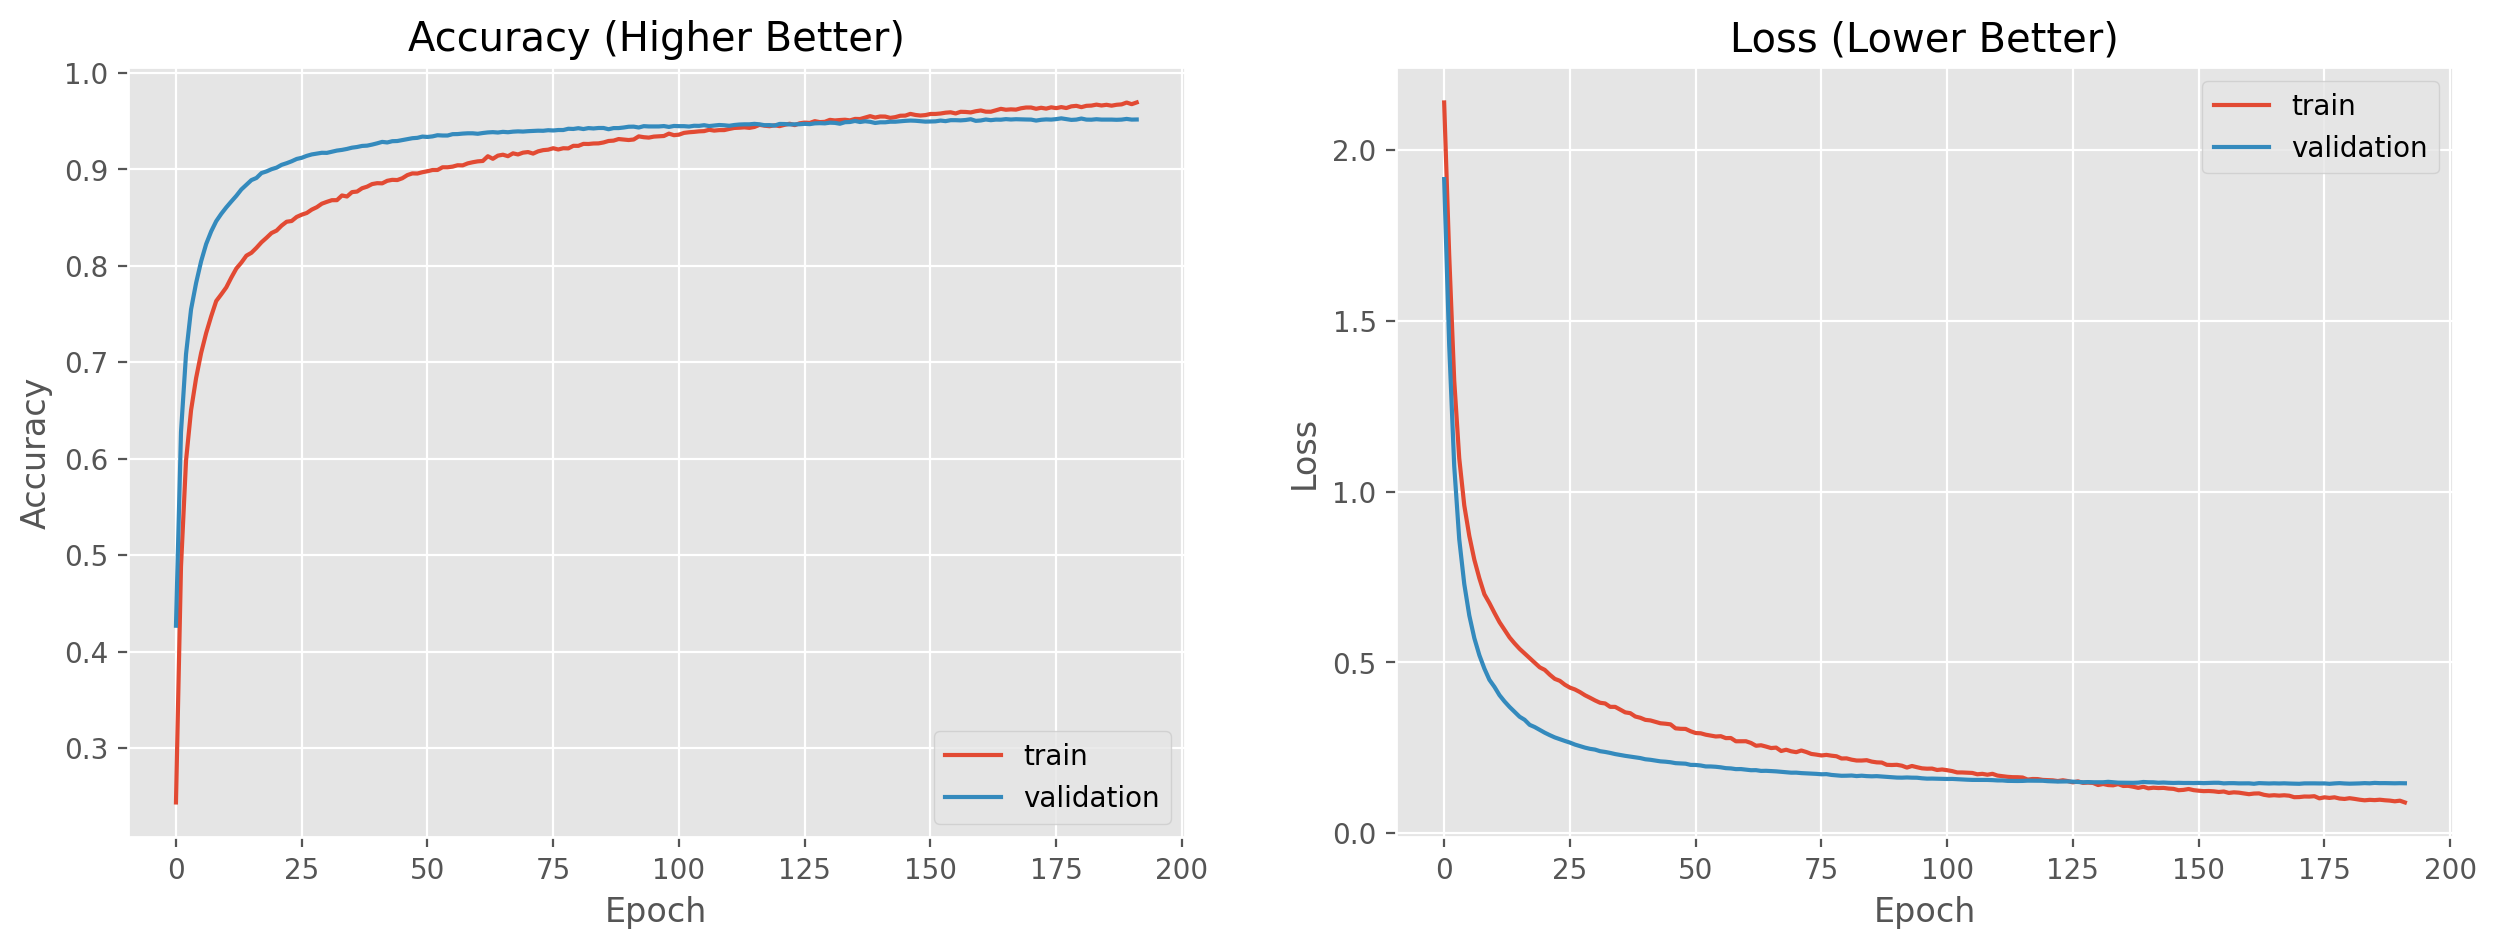

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 7s 36ms/step
[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


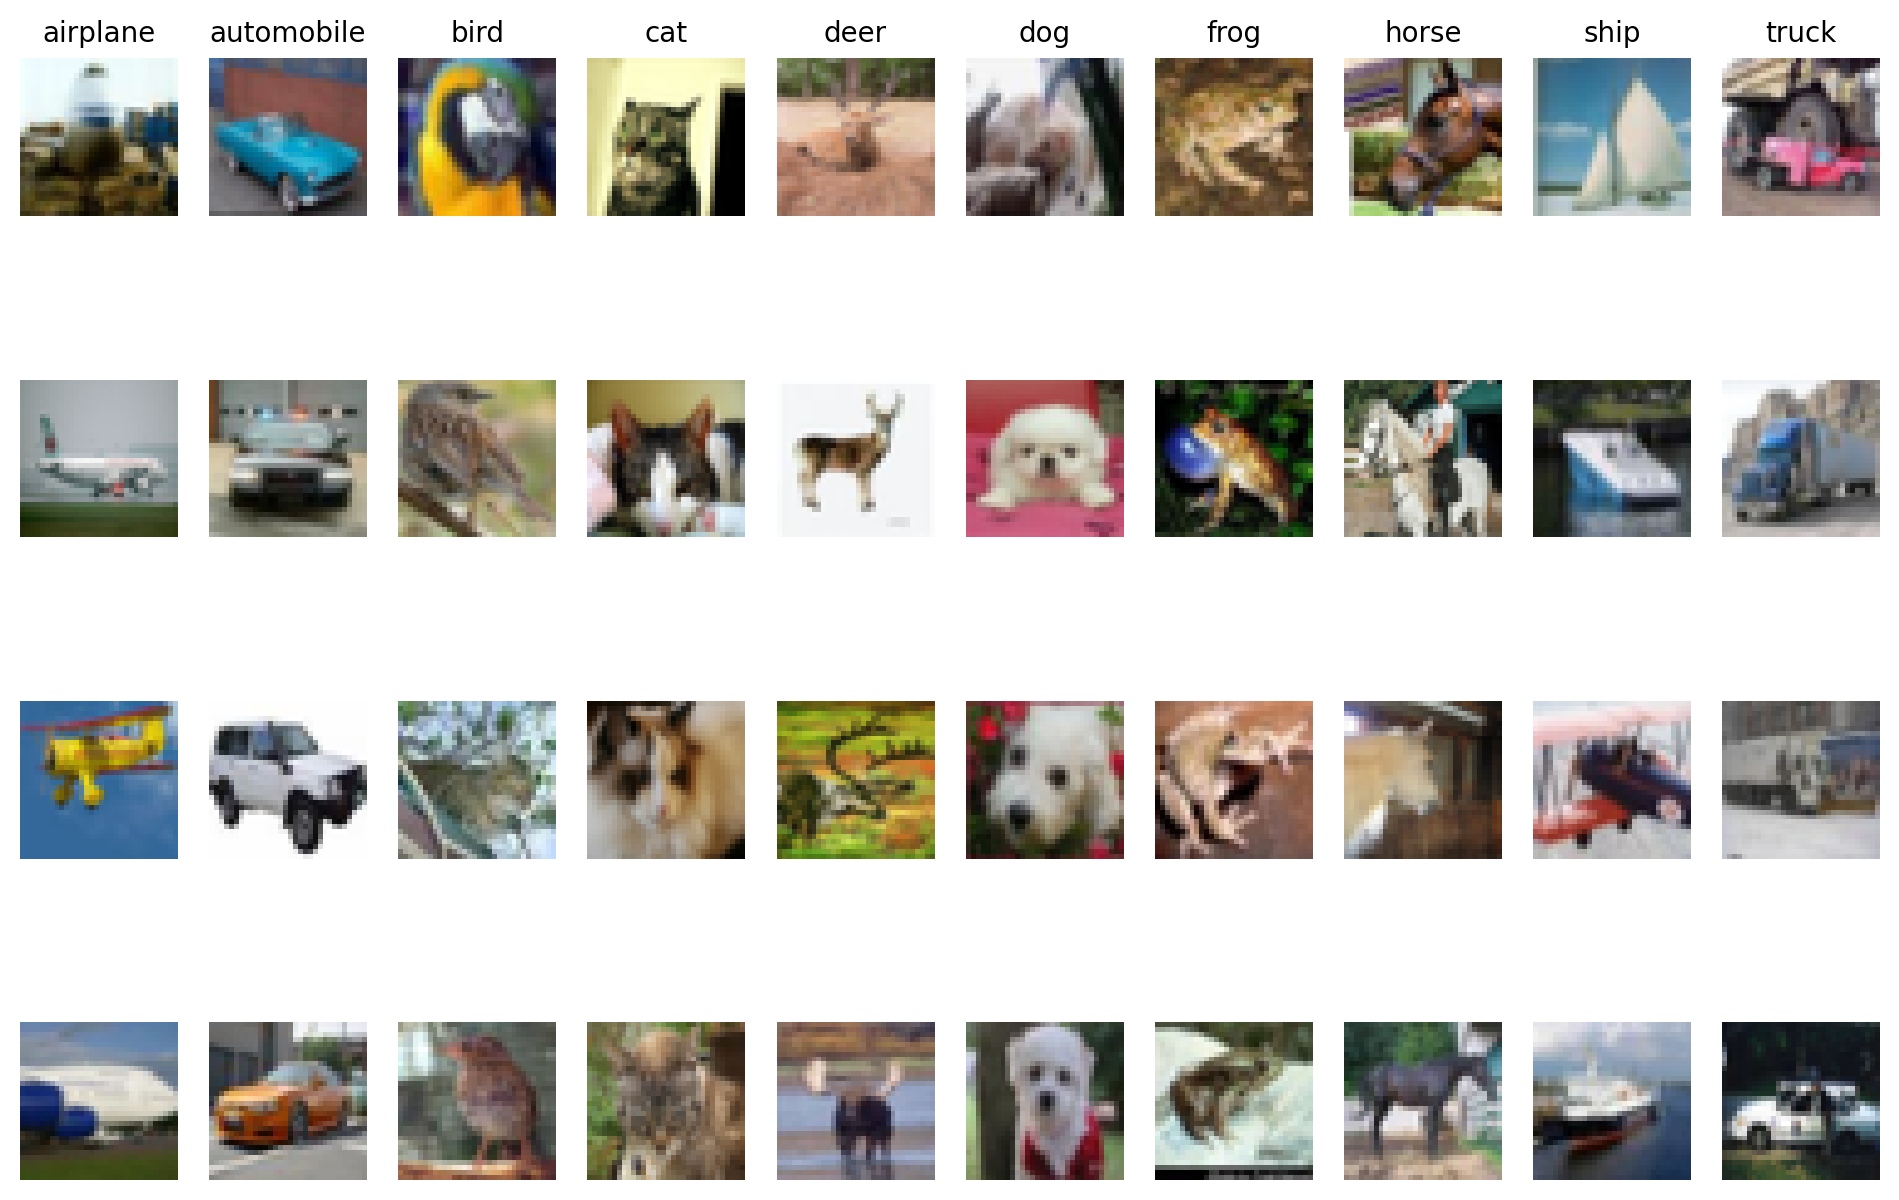

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


### <font color=marroon>Model Evaluation </font>
- Comparing our results from our baseline, we are able to see that our accuracy increased from 0.91 to 0.954 between our baseline and our final model.
- Our loss decreased from 0.27 to 0.14 where our model performed better and has a better generalisation. 
- This could be the reason of our model's complexity and tuning from our cifar10 dataset. 
- Comparing the graphs of our accuracy, we can see that our model performed significatnly better than our baseline model where the validation score remained higher than the training set majority of the time in our final model. 
- The test loss has also decreased significantly as compared to our baseline model indicating that our performance has improved. 
- Furthermore, our validation scores remained higher than our training score indicating that there are very little signs of overfitting. The scores for training and validation remained closer together meaning our model made a good generalisation of our dataset. 

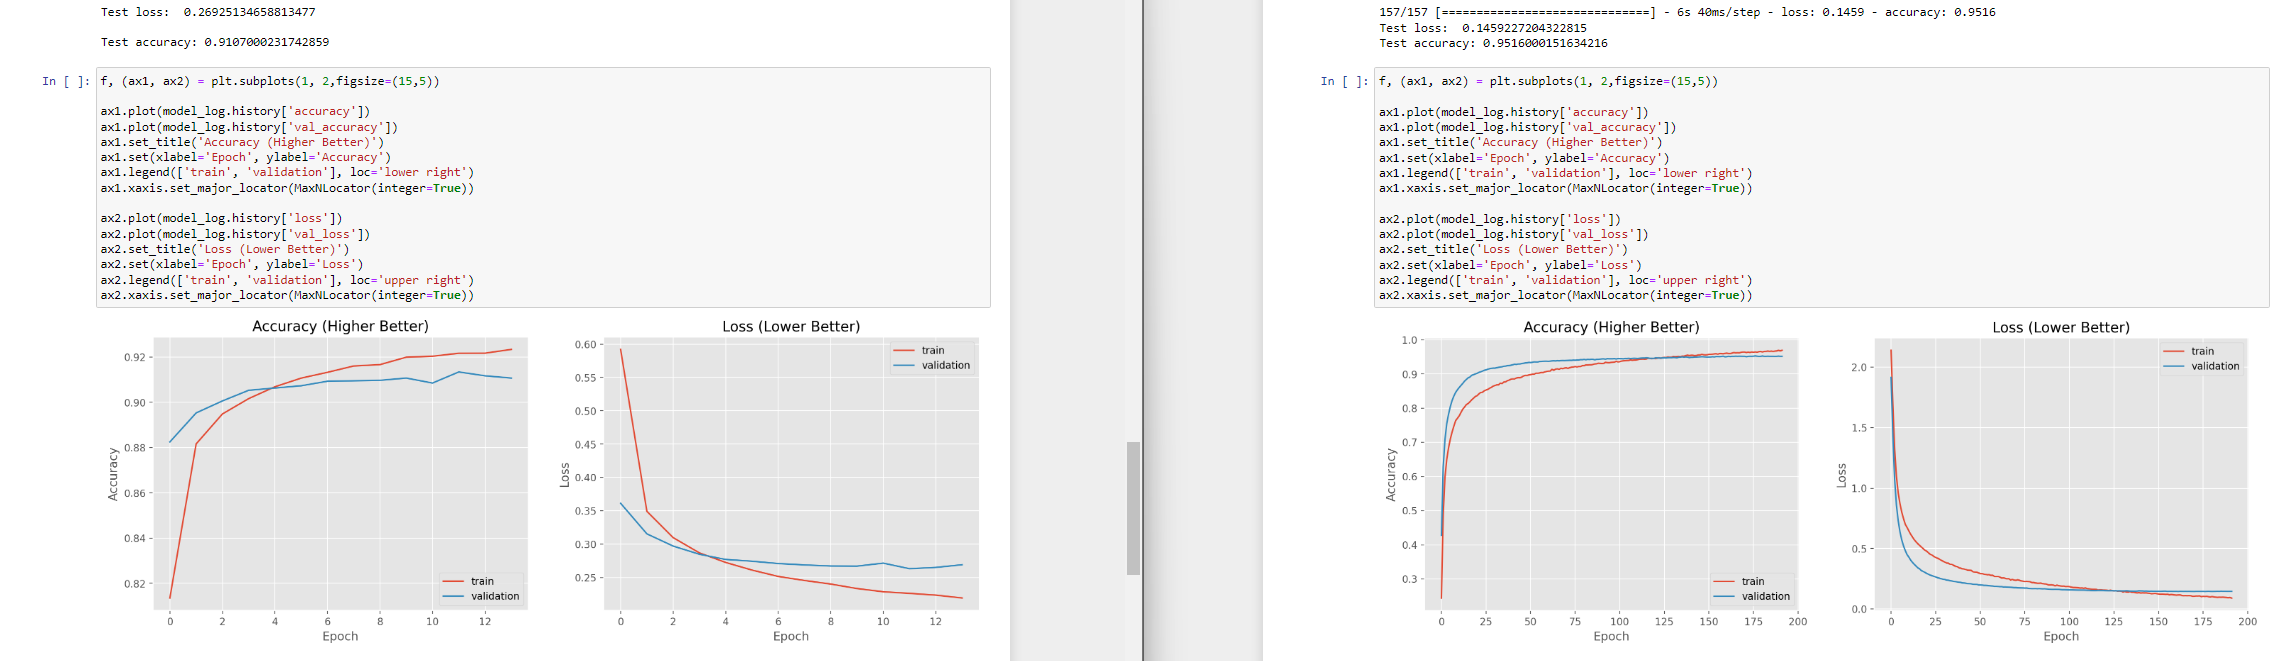

In [ ]:
# convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa8ijb3hr/assets


INFO:tensorflow:Assets written to: /tmp/tmpa8ijb3hr/assets
2023-05-31 13:42:55.895622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-31 13:42:55.895685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-31 13:42:55.896549: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa8ijb3hr
2023-05-31 13:42:55.964364: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-31 13:42:55.964417: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa8ijb3hr
2023-05-31 13:42:56.165397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-05-31 13:42:56.267848: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-05-31 13:42:57.714505: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [ ]:
import requests
from PIL import Image
from io import BytesIO

In [ ]:
image_url = "https://ih1.redbubble.net/image.2756771535.7009/st,small,507x507-pad,600x600,f8f8f8.jpg"  # Replace with the URL of your image

In [ ]:
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

In [ ]:
img = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

### Predict Image

In [ ]:
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)

1/1 [==============================] - 0s 34ms/step


In [ ]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Get predicted label

In [ ]:
predicted_label = class_labels[predicted_class_index[0]]

In [ ]:
print(predicted_label)


dog


### <font color=maroon>Visualising confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
correct = y_test  # Correct labels
predicted_labels = output  # Predicted labels

### Calculation of accuracy

In [ ]:
accuracy = accuracy_score(correct, predicted_labels)
print('Accuracy:', accuracy)

Accuracy: 0.9516


In [ ]:
precision = precision_score(correct, predicted_labels, average='weighted')
recall = recall_score(correct, predicted_labels, average='weighted')
f1 = f1_score(correct, predicted_labels, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.9515076150942164
Recall: 0.9516
F1 Score: 0.9514704944478471


### Creating confusion matrix

In [ ]:

cm = confusion_matrix(correct, predicted_labels)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

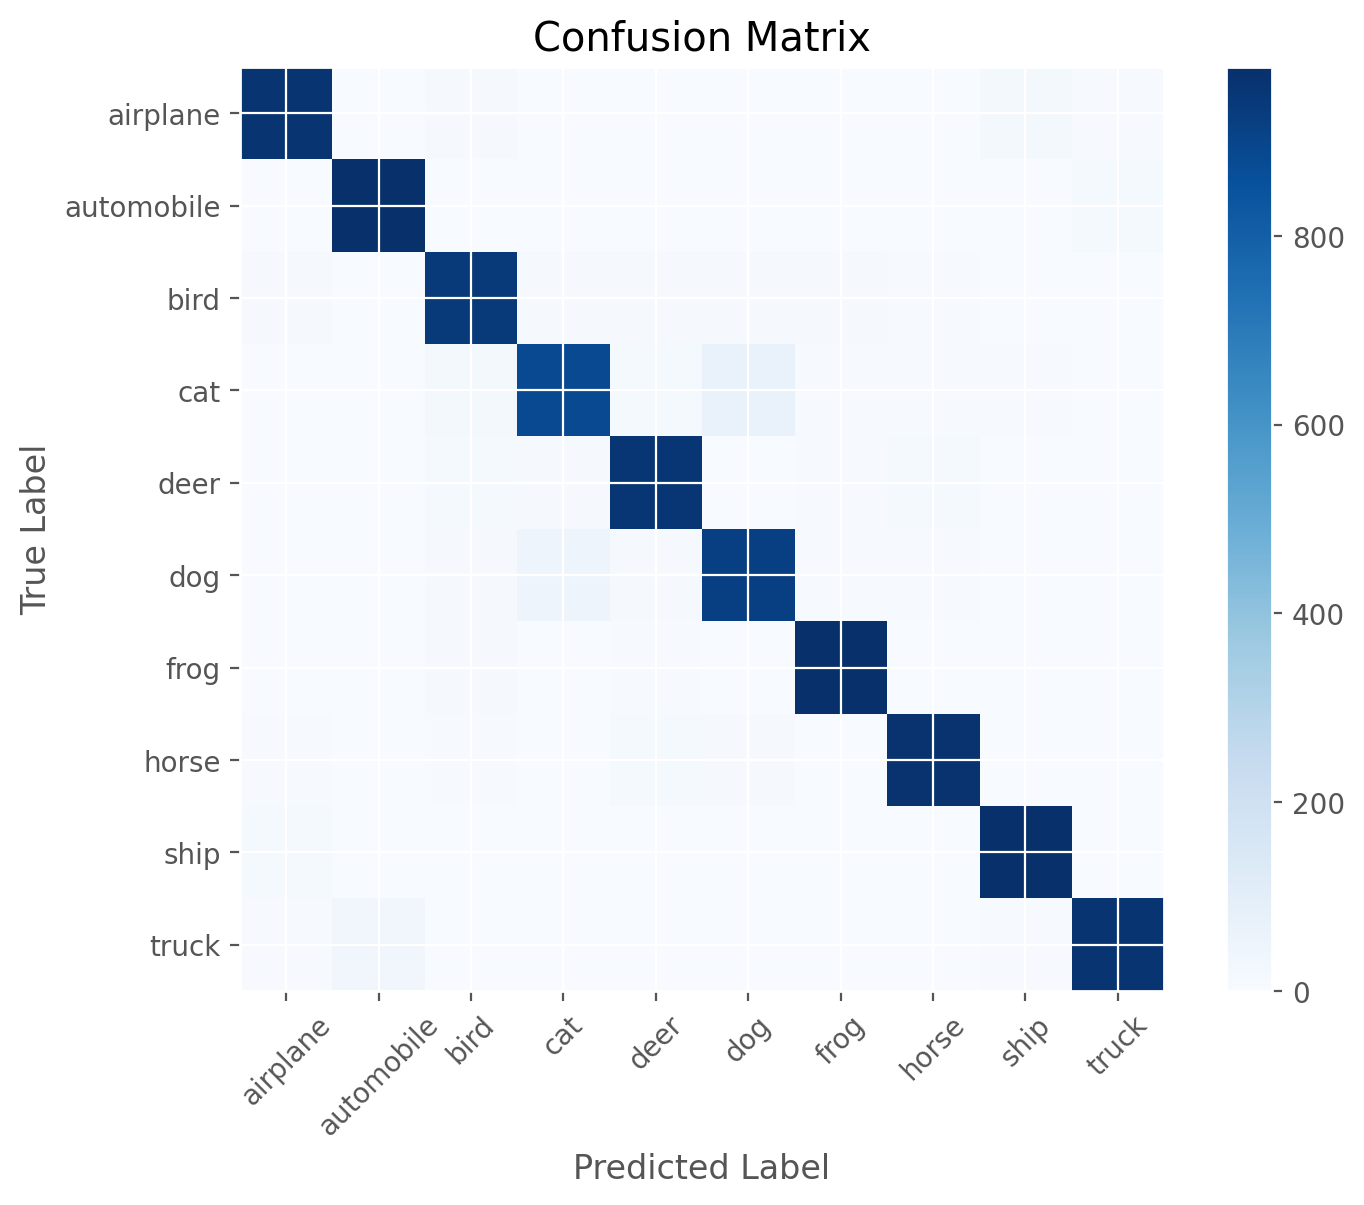

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
report = classification_report(correct, predicted_labels, target_names=class_labels)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

    airplane       0.96      0.96      0.96      1000
  automobile       0.97      0.98      0.97      1000
        bird       0.94      0.94      0.94      1000
         cat       0.93      0.88      0.91      1000
        deer       0.95      0.96      0.95      1000
         dog       0.91      0.92      0.91      1000
        frog       0.96      0.98      0.97      1000
       horse       0.97      0.96      0.97      1000
        ship       0.96      0.98      0.97      1000
       truck       0.97      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



### <font color=maroon>Model Evaluation 2</font>
- For our confusion matrix, we are able to see the comparison between our actual vs predicted labels. 
- From our confusion matrix above, we can see that our predicted labels lie alogng the diagonal where we can see there are lesser erorrs in our predictions.
- In our classifciation report above, we are able to see that our percisions remain above 0.9 where dog has the lowest percision score. A higher percision score indicates that there are lesser fewer positives meaning the model is maker lesser incorrect positive predictions. 

- The recall also shows that our models are able to identify the positive instances where it shows the number of correctly predicted instances over the actual positive instances. A high recall ratio indicates a better score of correctly predicted images. 

- Since our recall score of all our categories remained above 0.90, we are able to conclude that our model has a better ability to corrrectly identify images. The f1 score also tells us a balance measure of the model's performance. Considering both percision and score. From our classification report above, we are already able to tell our model performed well and we are able to deploy it onto android studio